<a href="https://colab.research.google.com/github/yukuproj/interviews/blob/main/probability_bid_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔮 Ad-Exchange Auction Prediction Problem


----
-----


---
----


 Problem Understanding

The task is to predict the probability of winning a bid in an ad-exchange auction, where the highest bid wins. This involves analyzing various features of the auction environment, such as bid prices, device types, and auction platforms, to build a machine learning model capable of accurately forecasting the auction outcomes. The model's performance will be evaluated using the F1 score, with the goal of exceeding the provided baseline score of 0.503.







### Solution steps:

The process involves the following steps:

1. **Google Drive Setup**: Mount Google Drive and load the datasets from the specified location.

2. **Loading the Utility Module**: The auxiliary functions and procedures are encapsulated in the `factor_utils.py` module. This module is loaded before proceeding with data analysis.

3. **One-Factor Analysis**: Conduct a descriptive analysis for each feature, identifying and visualizing the relationships between them and the target variable.

4. **Model Construction and Performance Comparison**:
   - Construct several models (Artificial Neural Networks (ANN), XGBoost, Decision Trees, Logistic Regression).
   - Compare the models using performance metrics such as F1-score and Gini or ROC AUC coefficient.

5. **Dataset Loading**: The dataset is loaded from a compressed file using `pandas.read_csv()`.

6. **Descriptive Analysis**: For each feature, the statistical properties and correlations with the target variable are explored.

7. **Feature Engineering**:
   - Numeric features undergo transformations such as logistic transformation to handle extreme values.
   - Categorical features are processed through grouping and Weight of Evidence (WOE) encoding to convert them into numeric representations.

8. **Outlier Detection and Removal**: Detect outliers and remove them from the dataset to improve model performance.

9. **Data Preprocessing**: Missing data is handled, redundant features are removed, and categorical variables are converted into dummy variables. This prepares the dataset for training machine learning models.

10. **Train-Test Split**: The dataset is split into training and testing sets to evaluate the performance of the models on unseen data.

11. **Data Normalization**: Features are normalized to ensure that models are trained on standardized data.

12. **Model Building**:
    - **ANN**: A simple feed-forward neural network is constructed, trained, and evaluated using the F1-score and Gini coefficient.
    - **XGBoost**: A gradient-boosting classifier is tuned through cross-validation and hyperparameter optimization. Performance is compared against the ANN model.
    - **Random Forest**: A Random Forest classifier is trained using hyperparameter tuning. It is evaluated using the same metrics.
    - **Logistic Regression**: A logistic regression model is built, evaluated, and compared to the previous models.

13. **Optimal Cutoff Calculation**: The optimal cutoff for classification is determined based on preserving the same mean probability of Bid.

14. **Visualization and Evaluation**:
   - Correlation heatmaps, ROC curves, and confusion matrices are plotted for each model to visualize their performance.
   - The models' Gini coefficients and F1-scores are compared for both training and testing sets.



This process leads to a comprehensive analysis and comparison of machine learning models for predicting the target variable, focusing on maximizing the performance metrics.



MAIN RESULT: models perfomance comparison (copied from the very end of this notebook!!!)

Red vertical lines here are the baseline levels

:Overlay
   .Bars.I  :Bars   [index,Variable]   (value)
   .HLine.I :HLine   [x,y]

:Overlay
   .Bars.I  :Bars   [index,Variable]   (value)
   .HLine.I :HLine   [x,y]

As the graphs indicate, all models outperformed the baseline in both the Gini coefficient and F1 score. For all models, the cutoff was chosen to maintain the same proportion of winning bids. However, determining the cutoff in this way caused the ANN model to show suboptimal performance in terms of F1 score, despite excelling in the Gini coefficient. This is because the ANN was trained with an optimization focus on the Gini coefficient. The F1 score is highly dependent on the cutoff for predicted probabilities. Nevertheless, if maintaining this proportion of winning bids is not a priority, a more optimal cutoff can be found to maximize the F1 score by iterating through different cutoff values within a certain range (specifically for the ANN model). Thus, with this adjustment, all models can be ensured to meet both the F1 score and Gini coefficient requirements.

## **SOLUTION:**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import zipfile
import pandas as pd
import sys

sys.path.append('/content/drive/MyDrive/data')
sys.path.append('/content/drive/MyDrive/python')
# read the dataset using the compression zip
data = pd.read_csv('/content/drive/MyDrive/data/train_data.zip',compression='zip')

In [3]:
import factor_utils # custom libary
from importlib import reload # reload
reload(factor_utils)

<module 'factor_utils' from '/content/drive/MyDrive/python/factor_utils.py'>

In [4]:
!pip install -U scikit-learn

In [5]:
!pip install hvplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.0/161.0 kB 7.0 MB/s eta 0:00:00


In [6]:
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [7]:
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [9]:
#data = pd.read_csv("train_data.csv")
data_test = pd.read_csv("/content/drive/MyDrive/data/test_data.csv")

In [9]:
data_test.columns

Index(['target', 'flr', 'sellerClearPrice', 'hour', 'ssp', 'dsp',
       'auctionBidFloorSource', 'sdk', 'sdkver', 'bundle', 'os', 'lang',
       'country', 'region', 'request_context_device_w',
       'request_context_device_h', 'bidderFlrPolicy', 'adt', 'dc', 'contype',
       'request_context_device_type', 'ifa', 'price'],
      dtype='object')

In [10]:
data.describe(include = "all")

target        flr  sellerClearPrice       hour        ssp  \
count  9640735.00 9640735.00        9640735.00 9640735.00 9640735.00   
unique        NaN        NaN               NaN        NaN        NaN   
top           NaN        NaN               NaN        NaN        NaN   
freq          NaN        NaN               NaN        NaN        NaN   
mean         0.08       2.97              3.31      11.56     157.00   
std          0.28       4.07              4.43       7.68       0.00   
min          0.00       0.01              0.01       0.00     157.00   
25%          0.00       0.69              0.83       4.00     157.00   
50%          0.00       1.49              1.78      12.00     157.00   
75%          0.00       4.65              4.41      19.00     157.00   
max          1.00     449.55            371.45      23.00     157.00   

              dsp auctionBidFloorSource         sdk   sdkver  \
count  9640735.00               9640735     9640733  9640733   
unique        NaN                     5           1       14   
top           NaN                    ml  BidMachine  2.4.0.2   
freq          NaN               4335419     9640733  5277994   
mean        81.02                   NaN         NaN      NaN   
std         24.99                   NaN         NaN      NaN   
min         23.00                   NaN         NaN      NaN   
25%         76.00                   NaN         NaN      NaN   
50%         80.00                   NaN         NaN      NaN   
75%         80.00                   NaN         NaN      NaN   
max        236.00                   NaN         NaN      NaN   

                                                   bundle       os     lang  \
count                                             9640735  9640734  9640734   
unique                                                  5        2     1303   
top     gAAAAABmcEFTEPcMMU786QLAISLs22JucTR9XWAoRq7NAM...      ios       en   
freq                                              5585485  5596411  5879832   
mean                                                  NaN      NaN      NaN   
std                                                   NaN      NaN      NaN   
min                                                   NaN      NaN      NaN   
25%                                                   NaN      NaN      NaN   
50%                                                   NaN      NaN      NaN   
75%                                                   NaN      NaN      NaN   
max                                                   NaN      NaN      NaN   

        country   region  request_context_device_w  request_context_device_h  \
count   9640734  9292023                9640734.00                9640734.00   
unique      121      565                       NaN                       NaN   
top          US       tx                       NaN                       NaN   
freq    4995857   468045                       NaN                       NaN   
mean        NaN      NaN                    693.22                   1365.05   
std         NaN      NaN                    289.04                    591.37   
min         NaN      NaN                    240.00                      2.00   
25%         NaN      NaN                    393.00                    852.00   
50%         NaN      NaN                    720.00                   1080.00   
75%         NaN      NaN                    900.00                   1800.00   
max         NaN      NaN                   3120.00                   4800.00   

       bidderFlrPolicy           adt       dc    contype  \
count          9640734       9640734  9640734 9640734.00   
unique               3             1        1        NaN   
top           original  interstitial       US        NaN   
freq           5703725       9640734  9640734        NaN   
mean               NaN           NaN      NaN       2.48   
std                NaN           NaN      NaN       1.18   
min                NaN           NaN      NaN  

# 🔍 Exploratory Data Analysis

> **OVERALL GOAL:**
> - Get an understanding for which variables are important, view summary statistics, and visualize the data

For each feature, we can determine the type of the variable (continuous or categorical) and assess whether it should be included in the preliminary list of features to be used for model construction.

continuous variables are marked with **bold**

* target - (0,1) - Target variable (indicating bid win or loss)
*  **flr** - (0.01 .. 449.55) - Continuous variable
* **sellerClearPrice** - (0.01 .. 371.45) - Continuous variable
* hour - (0 .. 23) - Time variable (can be transformed into a categorical variable or used to create sine and cosine features to capture the cyclical nature of time)
* ssp - Only one value (157) - Exclude this feature
* dsp - (23 .. 236) - Categorical variable
* auctionBidFloorSource - (lurl, ml_original, rollouts, user_ml) - Categorical variable
* sdk - Only one value (Bidmachine) - Exclude this feature
* sdkver - (1.9.10 .. 2.5.0) - Categorical variable
* bundle - (#5 different values) - Categorical variable
* os - (android, ios) - Categorical variable
* lang - (#1303 different values) - Categorical variable
* country - (#121 values) - Categorical variable
* region - (#565 values) - Categorical variable
* **request_context_device_w** - Continuous variable
* **request_context_device_h** - Continuous variable
* bidderFlrPolicy - (#3 values) - Categorical variable
* adt - Only one value - Exclude this feature
* dc - Only one value - Exclude this feature
* contype - (0 .. 7) - Categorical variable
* request_context_device_type - (1, 4, 5) - Categorical variable
* ifa - (#990,006 values) - Too many unique IDs, unnecessary for this task
* **price** - Continuous variable

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9640735 entries, 0 to 9640734
Data columns (total 23 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   target                       int64  
 1   flr                          float64
 2   sellerClearPrice             float64
 3   hour                         int64  
 4   ssp                          int64  
 5   dsp                          int64  
 6   auctionBidFloorSource        object 
 7   sdk                          object 
 8   sdkver                       object 
 9   bundle                       object 
 10  os                           object 
 11  lang                         object 
 12  country                      object 
 13  region                       object 
 14  request_context_device_w     float64
 15  request_context_device_h     float64
 16  bidderFlrPolicy              object 
 17  adt                          object 
 18  dc                           object 
 19  

In [10]:
numeric_features = ['flr', 'sellerClearPrice', 'request_context_device_w', 'request_context_device_h', 'price']
time_feature = 'hour'
categoric_features = ['ssp', 'dsp', 'auctionBidFloorSource', 'sdk', 'sdkver', 'bundle', 'os', 'lang',
                      'country', 'region', 'bidderFlrPolicy', 'adt', 'dc', 'contype', 'request_context_device_type', 'ifa']
target_feature = 'target'
print(len(numeric_features)  + len(time_feature) + len(categoric_features) )

25


In [13]:
for name in data.columns:
    if (name not in categoric_features):
        if (name not in numeric_features):
            if (name  not in time_feature):
                    print("missing feature:" + name)

missing feature:target


## 🎯 ✔️ `Target`

In [11]:
target_mean = data.target.mean()
print(target_mean)
#0.0831950053600685 on the whole dataset

0.0831950053600685


## Sampling for Analysis

We can sample from the entire dataset for analysis and model building. As demonstrated by multiple runs of this notebook, there is not much difference in the results when conducting analysis on a sample of 50,000 observations. However, we can still evaluate our model on the entire test set.

In [12]:
data = data.sample(n=50000) #randomly sample from the whole population

## ✔️ One factor analysis  ( `numeric_features`)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 0.009999998
max = 125.0
after cutting: min =0.0106
after cutting: max =9.04542014999999
Start plotting...
 min x for ROC 0.0106 max x for ROC 9.04542014999999
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


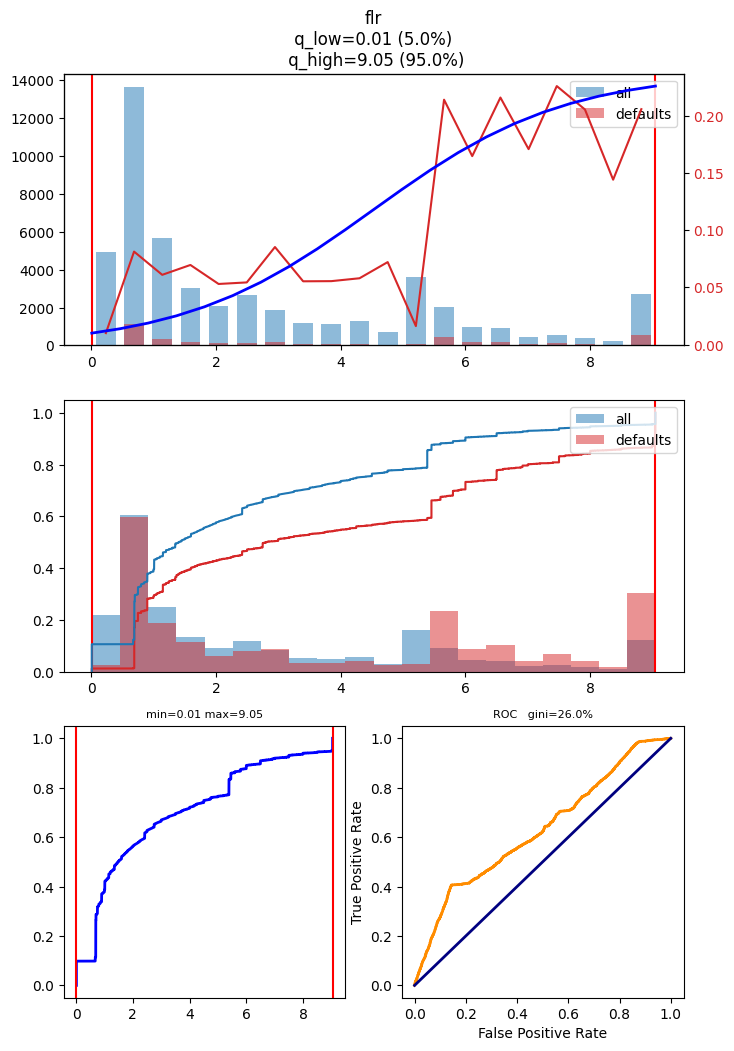

In [16]:
make_graphs_for_features = True

f_name = "flr"

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 0.010153994
max = 133.72937
after cutting: min =0.500577
after cutting: max =10.258070049999986
Start plotting...
 min x for ROC 0.500577 max x for ROC 10.258070049999986
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


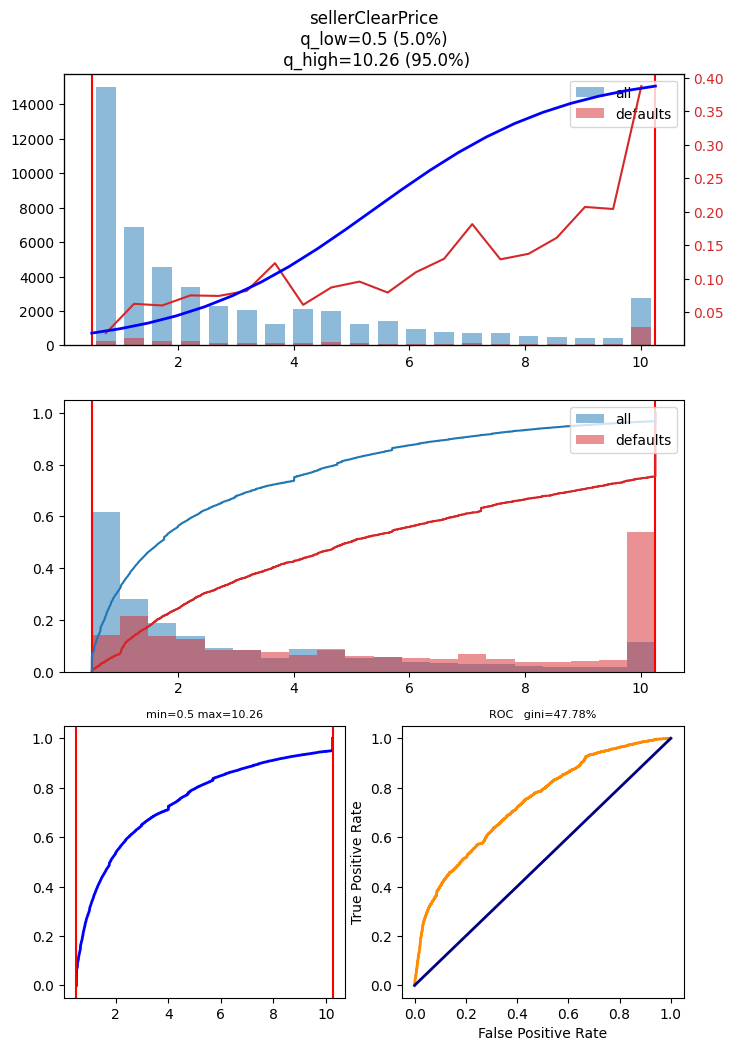

In [17]:
f_name = "sellerClearPrice"

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 320.0
max = 2340.0
after cutting: min =375.0
after cutting: max =1080.0
Start plotting...
 min x for ROC 375.0 max x for ROC 1080.0
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


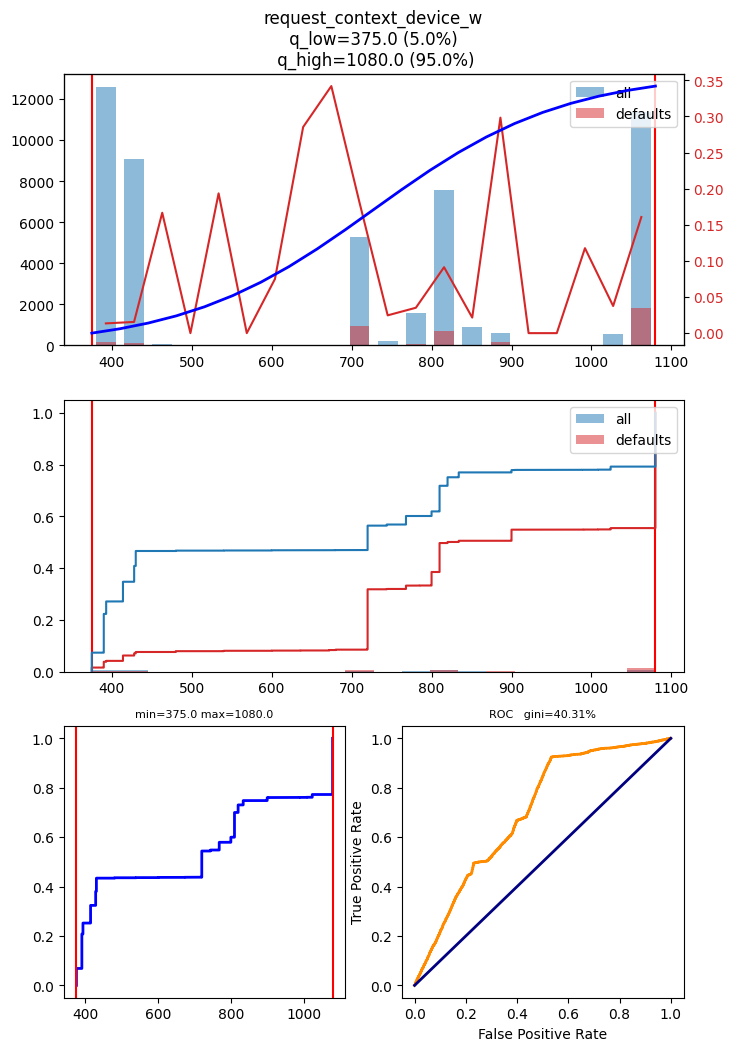

In [18]:
f_name = 'request_context_device_w'

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 568.0
max = 3216.0
after cutting: min =812.0
after cutting: max =2400.0
Start plotting...
 min x for ROC 812.0 max x for ROC 2400.0
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


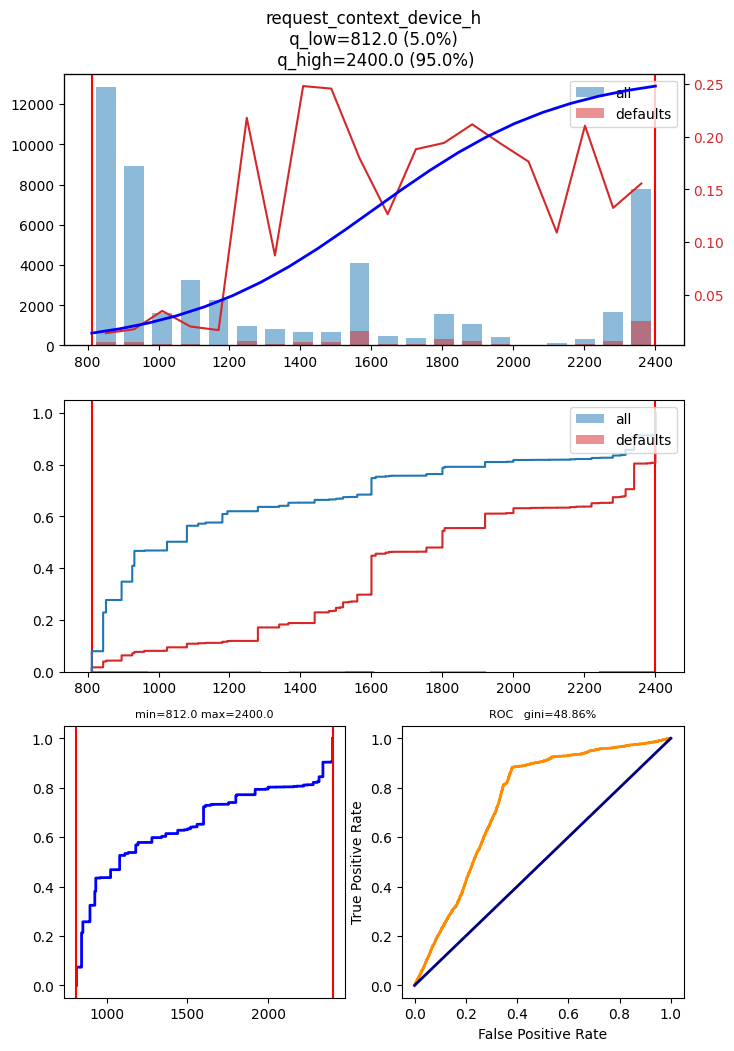

In [19]:
f_name = 'request_context_device_h'

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 0.010687932
max = 180.00989
after cutting: min =0.6914997
after cutting: max =13.822896299999988
Start plotting...
 min x for ROC 0.6914997 max x for ROC 13.822896299999988
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


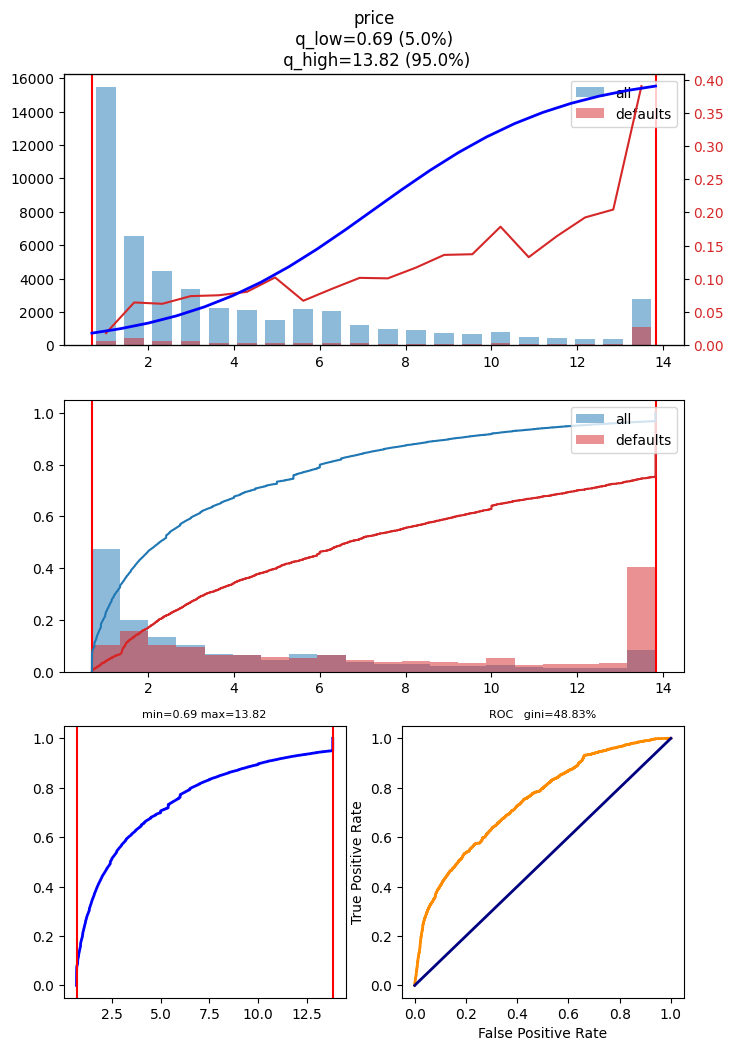

In [20]:
f_name =  'price'

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

#Creating new time-based features

In [21]:
time_feature = 'hour'
# Преобразование в синус и косинус
data['hour_sin'] = np.sin(2 * np.pi * data[time_feature] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data[time_feature] / 24)

#test
data_test['hour_sin'] = np.sin(2 * np.pi * data_test[time_feature] / 24)
data_test['hour_cos'] = np.cos(2 * np.pi * data_test[time_feature] / 24)

<Axes: >

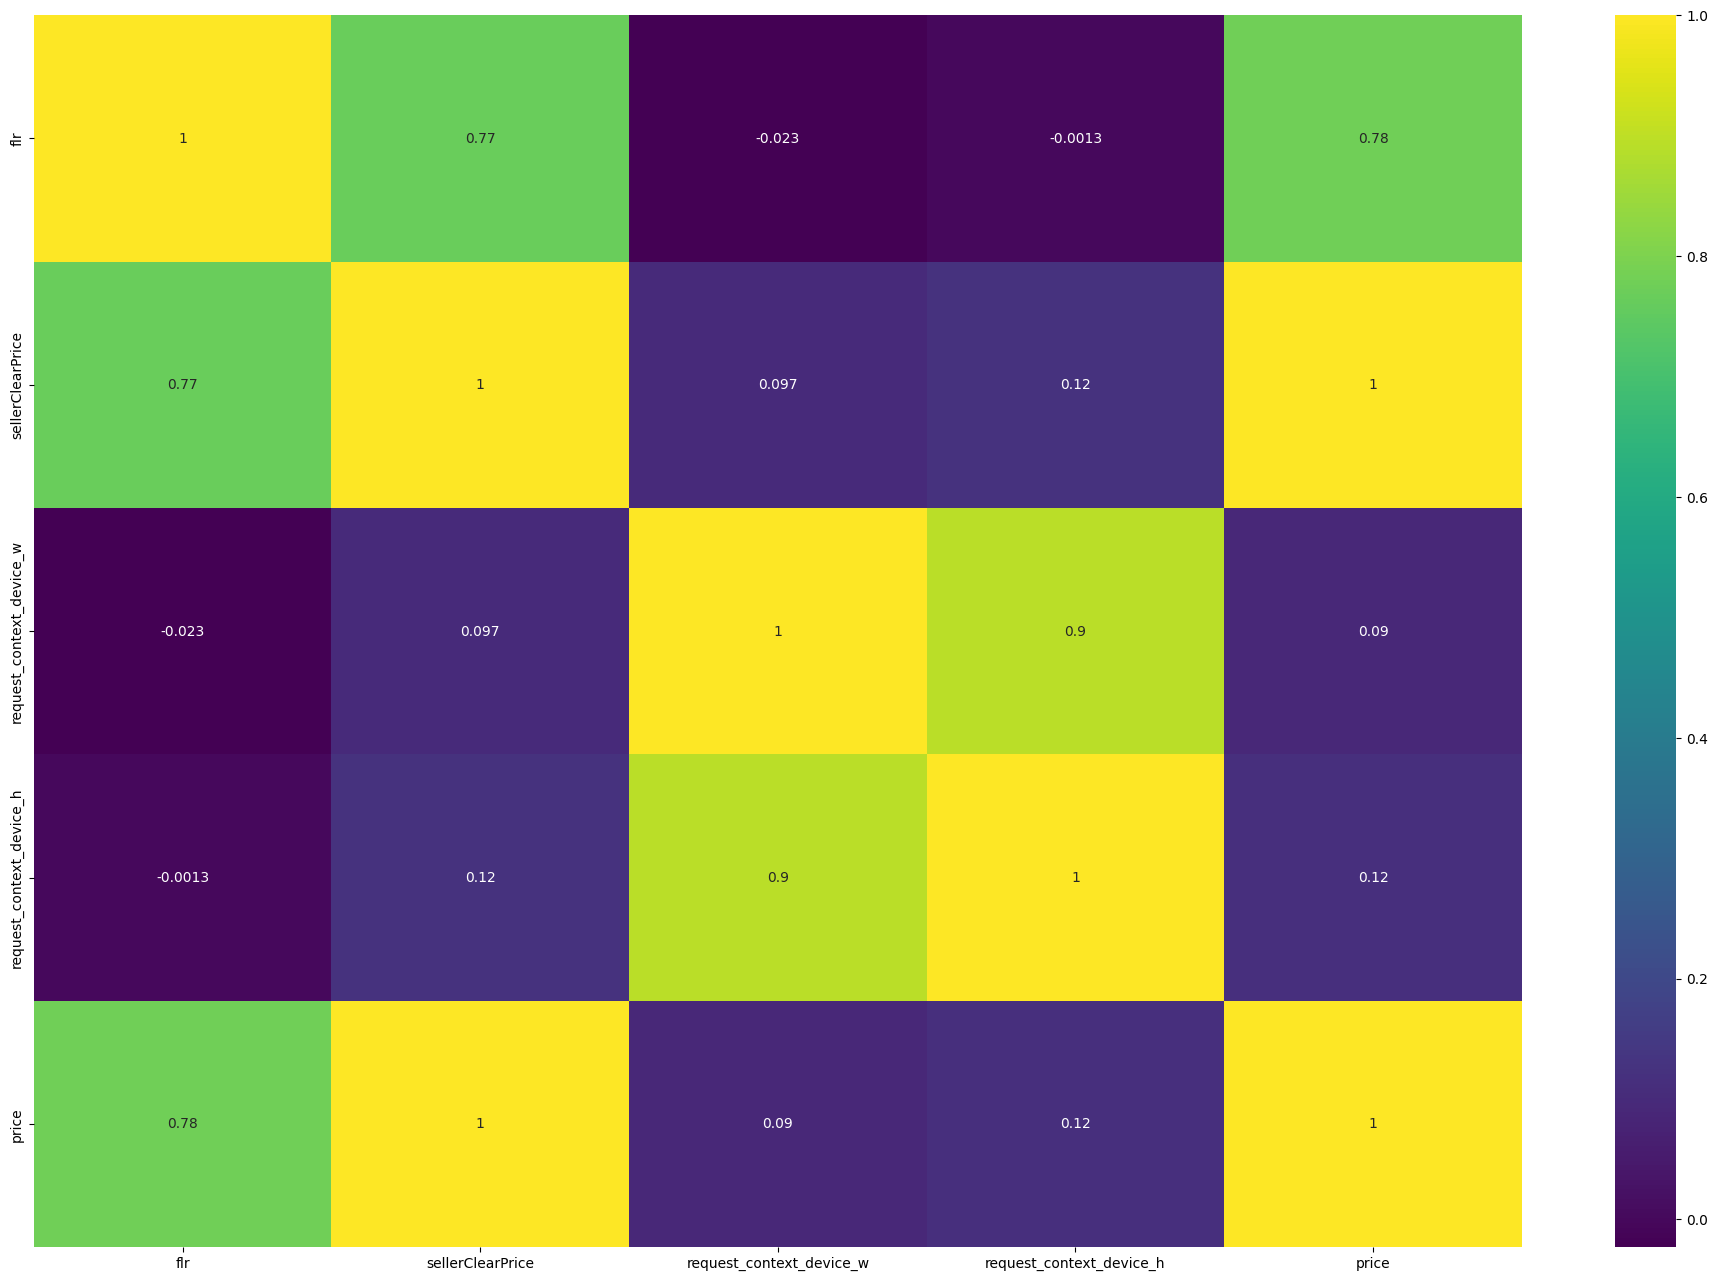

In [22]:
plt.figure(figsize=(24, 16))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='viridis')

 Result -> It is evident that three features—**flr**, **sellerClearPrice**, and **price**—are highly correlated, as well as two features—**request_context_device_w** and **request_context_device_h**. Keeping all of them is not necessarily a problem, but if we later decide to use a logistic regression model, it would be better to select only one feature from each of these groups to reduce the variance in the estimation of the logistic regression coefficients.



#### Adding new features to the dataset, applying a logistic transformation

In [13]:
for fName in numeric_features:
    x = data[fName]
    p_low = 0.05
    p_high = 0.95
    low_quant = x.quantile(p_low)
    high_quant = x.quantile(p_high)
    logistic_factor = factor_utils.logistic_transformation(x, low_quant, high_quant)['values']
    data.drop(columns = fName, inplace = True)
    newName = fName + "_logistic"
    data[newName] = logistic_factor

#test
    x = data_test[fName]
    logistic_factor = factor_utils.logistic_transformation(x, low_quant, high_quant)['values']
    data_test.drop(columns = fName, inplace=True)
    newName = fName + "_logistic"
    data_test[newName] = logistic_factor

In [14]:
numeric_features_selected = ['flr_logistic', 'sellerClearPrice_logistic', 'request_context_device_w_logistic', 'request_context_device_h_logistic', 'price_logistic']

In [25]:
data.columns

Index(['target', 'hour', 'ssp', 'dsp', 'auctionBidFloorSource', 'sdk',
       'sdkver', 'bundle', 'os', 'lang', 'country', 'region',
       'bidderFlrPolicy', 'adt', 'dc', 'contype',
       'request_context_device_type', 'ifa', 'hour_sin', 'hour_cos',
       'flr_logistic', 'sellerClearPrice_logistic',
       'request_context_device_w_logistic',
       'request_context_device_h_logistic', 'price_logistic'],
      dtype='object')

## ✔️ One factor analysis

## ✔️ One factor analysis  ( `categorical_features`)

In [26]:
categoric_features

['ssp',
 'dsp',
 'auctionBidFloorSource',
 'sdk',
 'sdkver',
 'bundle',
 'os',
 'lang',
 'country',
 'region',
 'bidderFlrPolicy',
 'adt',
 'dc',
 'contype',
 'request_context_device_type',
 'ifa']

In [15]:
factor_name = 'dsp'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
df

Value    All   Good   Bad  Distr_Good  Distr_Bad   WoE   IV   PD  \
0      80  30404  29888   516        0.65       0.13  1.64 0.86 0.01   
1      76   7960   5249  2711        0.11       0.66 -1.75 0.96 0.05   
2      41   5101   5053    48        0.11       0.01  2.24 0.22 0.00   
5     122   2733   2229   504        0.05       0.12 -0.93 0.07 0.01   
4      87   1217   1170    47        0.03       0.01  0.80 0.01 0.00   
10    104    668    636    32        0.01       0.01  0.57 0.00 0.00   
9     227    557    541    16        0.01       0.00  1.11 0.01 0.00   
3      46    323    300    23        0.01       0.01  0.15 0.00 0.00   
11    132    307    306     1        0.01       0.00  3.31 0.02 0.00   
7     180    285    138   147        0.00       0.04 -2.48 0.08 0.00   
8     149    201    161    40        0.00       0.01 -1.02 0.01 0.00   
6      79     75     72     3        0.00       0.00  0.76 0.00 0.00   
13    103     44     37     7        0.00       0.00 -0.75 0.00 0.00   
12    207     40     39     1        0.00       0.00  1.25 0.00 0.00   
15     84     36     36     0        0.00       0.00  0.00 0.00 0.00   
14    191     24     20     4        0.00       0.00 -0.81 0.00 0.00   
19    100      6      6     0        0.00       0.00  0.00 0.00 0.00   
18     45      5      3     2        0.00       0.00 -2.01 0.00 0.00   
21    222      4      3     1        0.00       0.00 -1.32 0.00 0.00   
16    236      3      3     0        0.00       0.00  0.00 0.00 0.00   
20     27      2      2     0        0.00       0.00  0.00 0.00 0.00   
23    206      2      2     0        0.00       0.00  0.00 0.00 0.00   
17    202      1      1     0        0.00       0.00  0.00 0.00 0.00   
22    226      1      1     0        0.00       0.00  0.00 0.00 0.00   
24     23      1      1     0        0.00       0.00  0.00 0.00 0.00   

    All_proc  All_cumm  All_cumm_proc  
0       0.61     30404           0.61  
1       0.16     38364           0.77  
2       0.10     43465           0.87  
5       0.05     46198           0.92  
4       0.02     47415           0.95  
10      0.01     48083           0.96  
9       0.01     48640           0.97  
3       0.01     48963           0.98  
11      0.01     49270           0.99  
7       0.01     49555           0.99  
8       0.00     49756           1.00  
6       0.00     49831           1.00  
13      0.00     49875           1.00  
12      0.00     49915           1.00  
15      0.00     49951           1.00  
14      0.00     49975           1.00  
19      0.00     49981           1.00  
18      0.00     49986           1.00  
21      0.00     49990           1.00  
16      0.00     49993           1.00  
20      0.00     49995           1.00  
23      0.00     49997           1.00  
17      0.00     49998           1.00  
22      0.00     49999           1.00  
24      0.00     50000           1.00

Each group (bin) should contain a sufficient number of observations to make the WOE statistically meaningful. A common recommendation is to have at least 3-5% of the total observations in each bin. So we keep only first top values with more than 3% of observations


  other values will be coded as "OTHER"

In [16]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])

In [17]:
values_to_keep

[80, 76, 41, 122]

In [18]:
# values_to_keep = [80, 76, 41, 122]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['dsp_grouped'] = data['dsp'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['dsp_grouped'] = data_test['dsp'].apply(lambda x: map_dict.get(x, default_value))

In [19]:
factor_name = 'dsp_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

In [20]:
df

Value    All   Good   Bad  Distr_Good  Distr_Bad   WoE   IV   PD  All_proc  \
1     80  30050  29542   508        0.64       0.12  1.67 0.87 0.01      0.60   
2     76   8268   5465  2803        0.12       0.67 -1.73 0.95 0.06      0.17   
4     41   5039   4988    51        0.11       0.01  2.19 0.21 0.00      0.10   
3  OTHER   3900   3583   317        0.08       0.08  0.03 0.00 0.01      0.08   
0    122   2743   2241   502        0.05       0.12 -0.90 0.06 0.01      0.05   

   All_cumm  All_cumm_proc  
1     30050           0.60  
2     38318           0.77  
4     43357           0.87  
3     47257           0.95  
0     50000           1.00

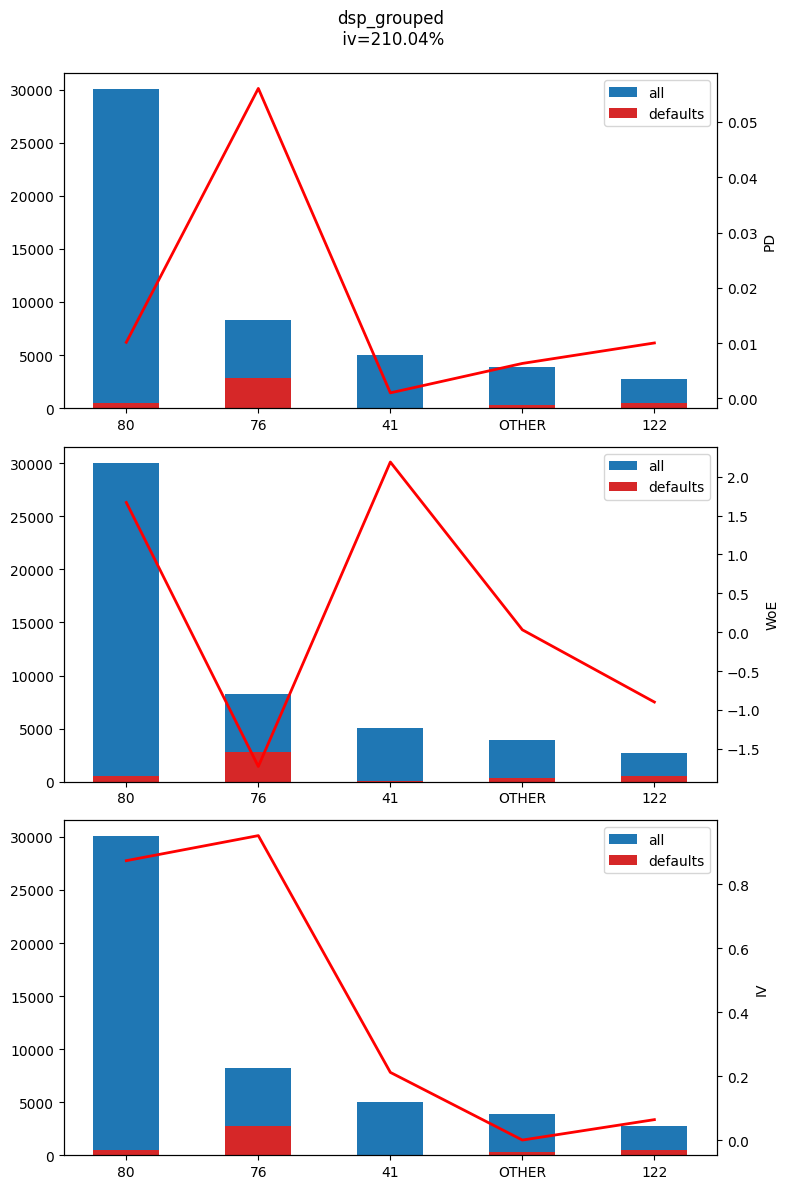

In [21]:
factor_utils.plot_iv(df, iv, factor_name)

In [22]:
factor_name = 'sdkver'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

In [36]:
df

Value    All   Good   Bad  Distr_Good  Distr_Bad   WoE   IV   PD  \
0   2.4.0.2  27609  27167   442        0.59       0.11  1.70 0.82 0.01   
1     2.5.0  18740  15433  3307        0.34       0.81 -0.87 0.41 0.07   
3     2.2.0    904    794   110        0.02       0.03 -0.44 0.00 0.00   
11  2.4.0.0    885    873    12        0.02       0.00  1.87 0.03 0.00   
9     2.3.3    847    680   167        0.01       0.04 -1.01 0.03 0.00   
10  2.1.0.0    329    326     3        0.01       0.00  2.27 0.01 0.00   
4   1.9.5.0    119    117     2        0.00       0.00  1.65 0.00 0.00   
13  2.3.0.2    110    109     1        0.00       0.00  2.28 0.00 0.00   
5   2.0.0.6    100     99     1        0.00       0.00  2.18 0.00 0.00   
7   1.9.4.1     85     85     0        0.00       0.00  0.00 0.00 0.00   
12    2.1.9     85     66    19        0.00       0.00 -1.17 0.00 0.00   
6     2.1.5     74     53    21        0.00       0.01 -1.49 0.01 0.00   
2    1.9.10     73     56    17        0.00       0.00 -1.22 0.00 0.00   
8   2.0.0.5     40     39     1        0.00       0.00  1.25 0.00 0.00   

    All_proc  All_cumm  All_cumm_proc  
0       0.55     27609           0.55  
1       0.37     46349           0.93  
3       0.02     47253           0.95  
11      0.02     48138           0.96  
9       0.02     48985           0.98  
10      0.01     49314           0.99  
4       0.00     49433           0.99  
13      0.00     49543           0.99  
5       0.00     49643           0.99  
7       0.00     49728           0.99  
12      0.00     49813           1.00  
6       0.00     49887           1.00  
2       0.00     49960           1.00  
8       0.00     50000           1.00

In [23]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["	2.4.0.2","2.5.0" , "2.4.0.0","2.2.0", "2.3.3", "2.1.0.0" ]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHERS"
data['sdkver_grouped'] = data['sdkver'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['sdkver_grouped'] = data_test['sdkver'].apply(lambda x: map_dict.get(x, default_value))

In [24]:
factor_name = 'sdkver_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

## Apply WOE (Weight of Evidence) transformation

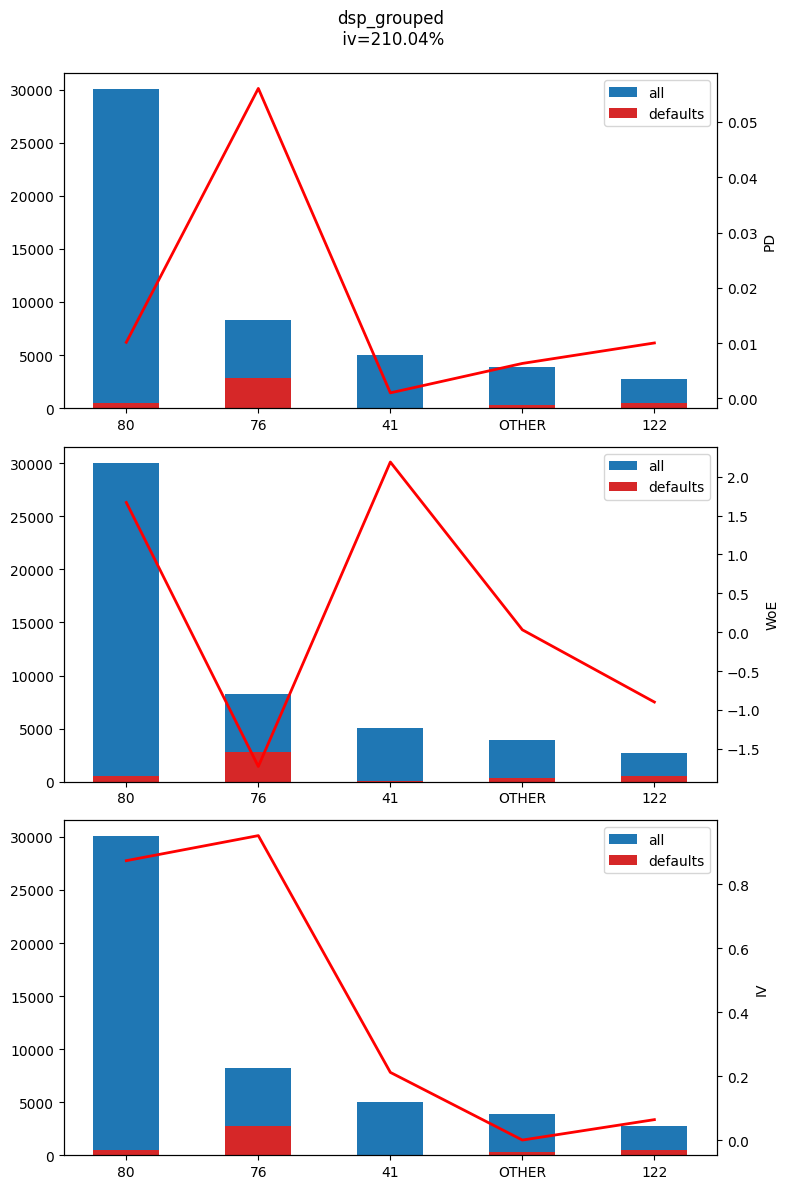

In [25]:
factor_name = 'dsp_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

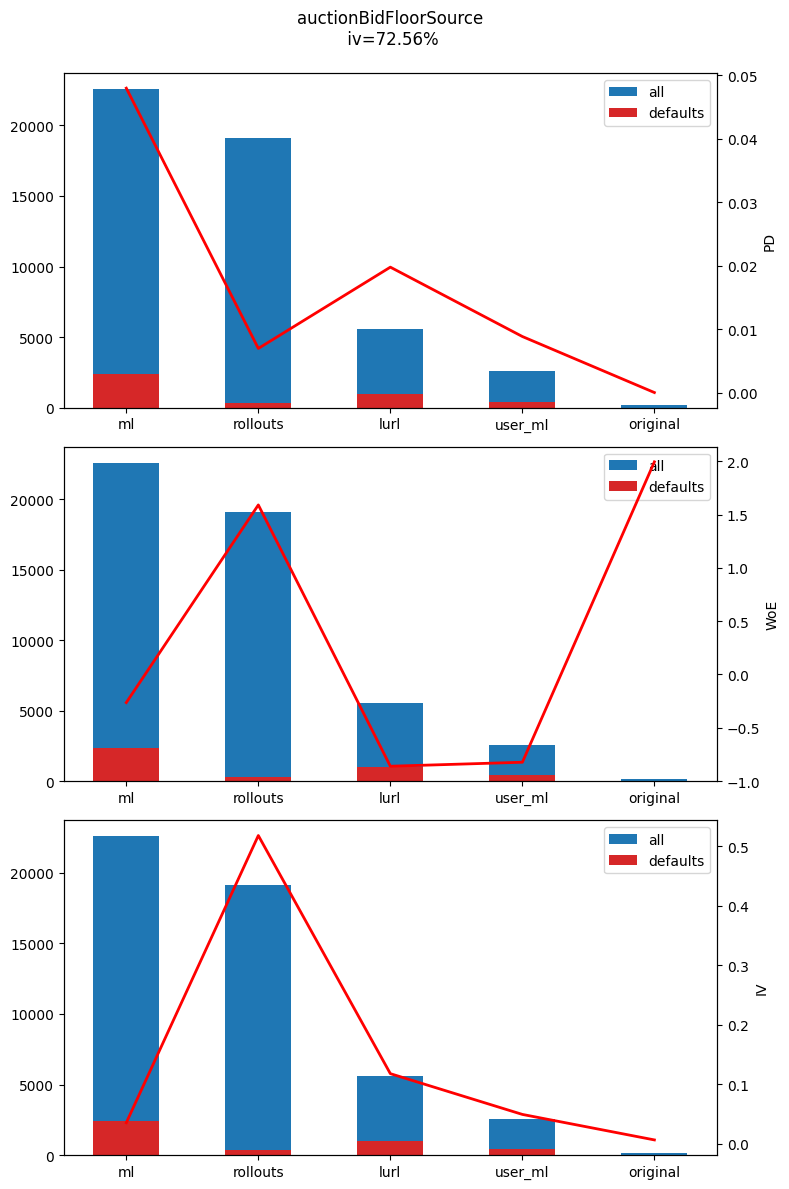

In [26]:
factor_name = 'auctionBidFloorSource'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

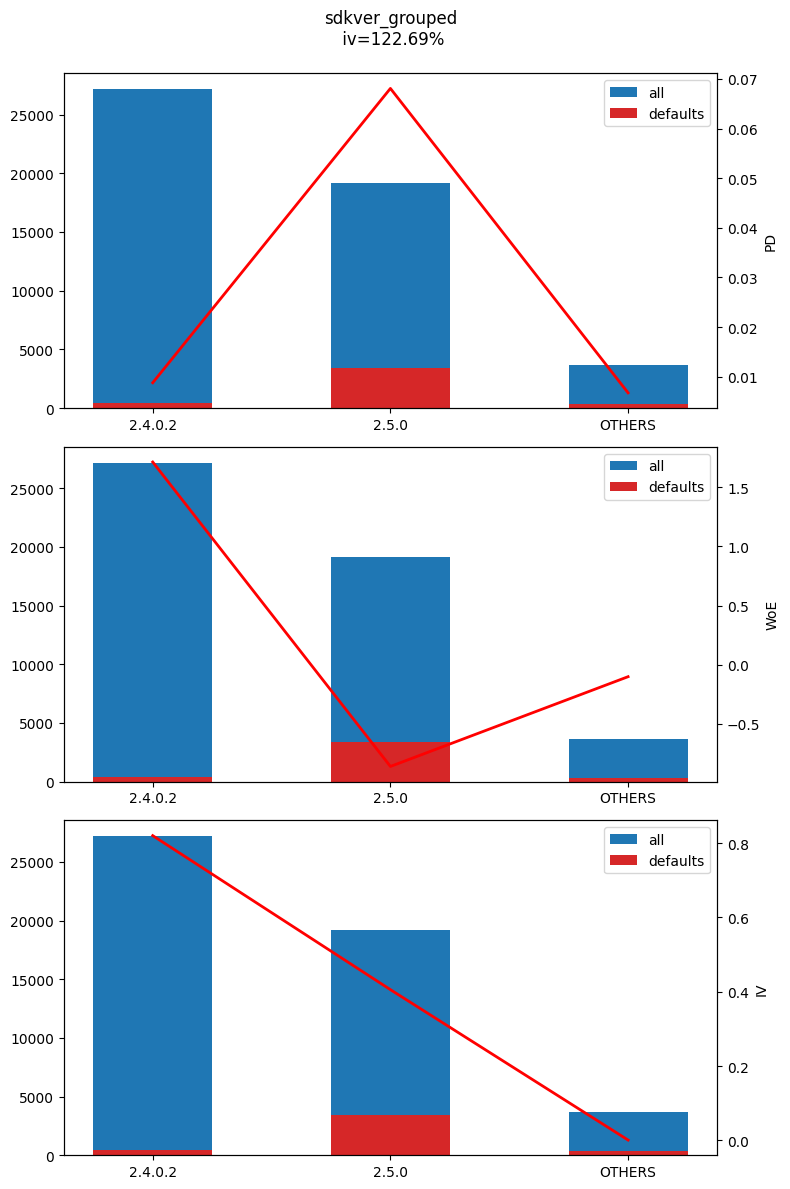

In [27]:
factor_name = 'sdkver_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

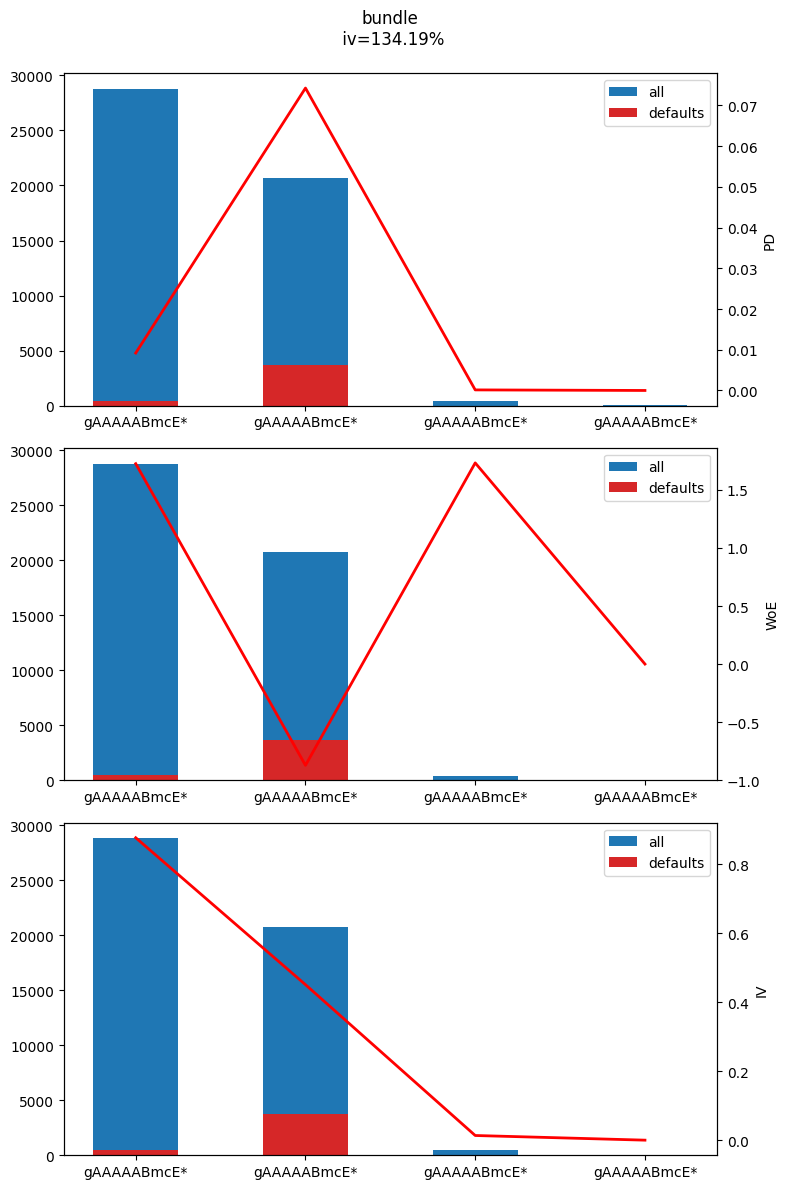

In [28]:
factor_name = 'bundle'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

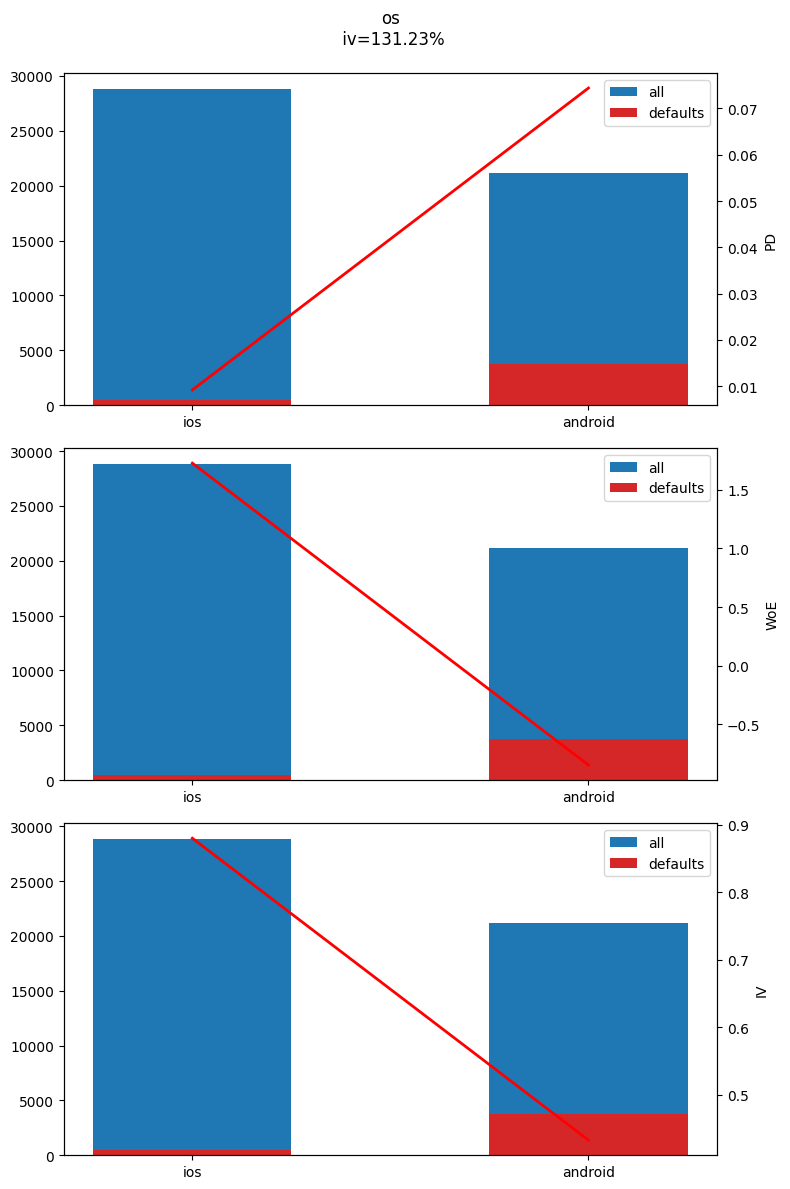

In [29]:
factor_name = 'os'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

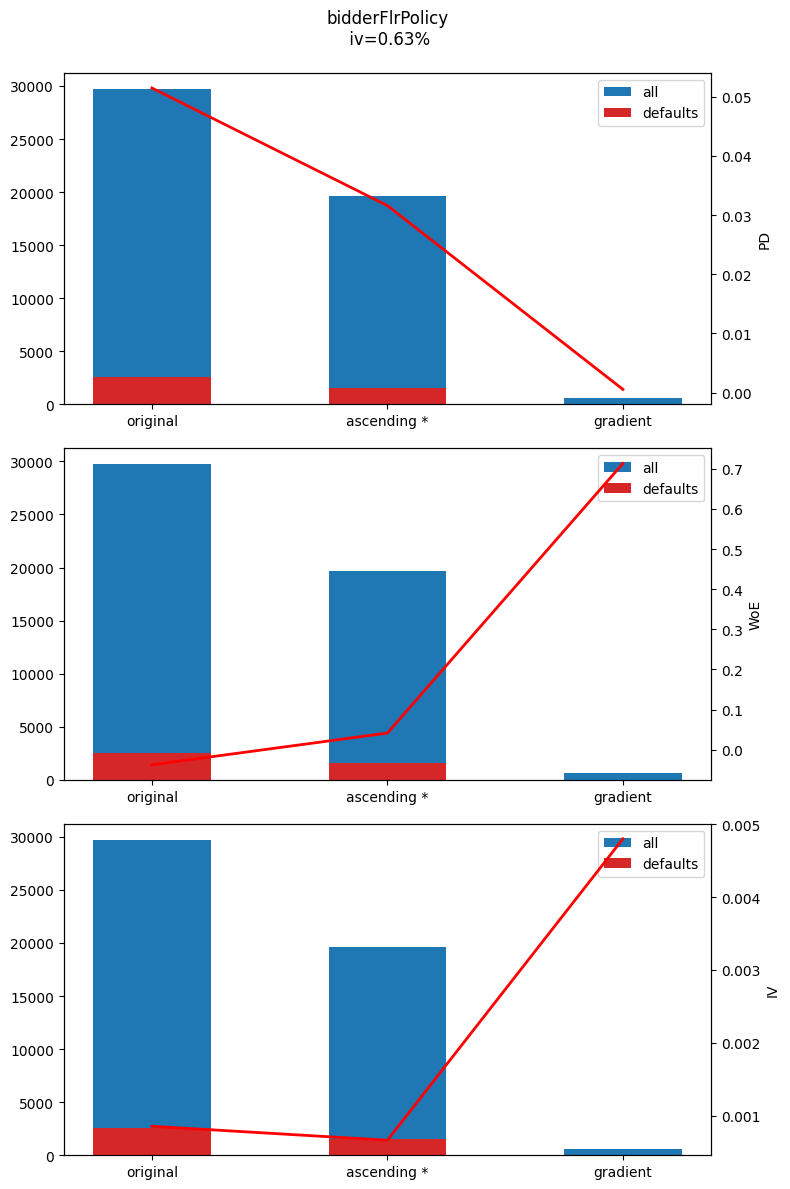

In [30]:
factor_name = 'bidderFlrPolicy'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

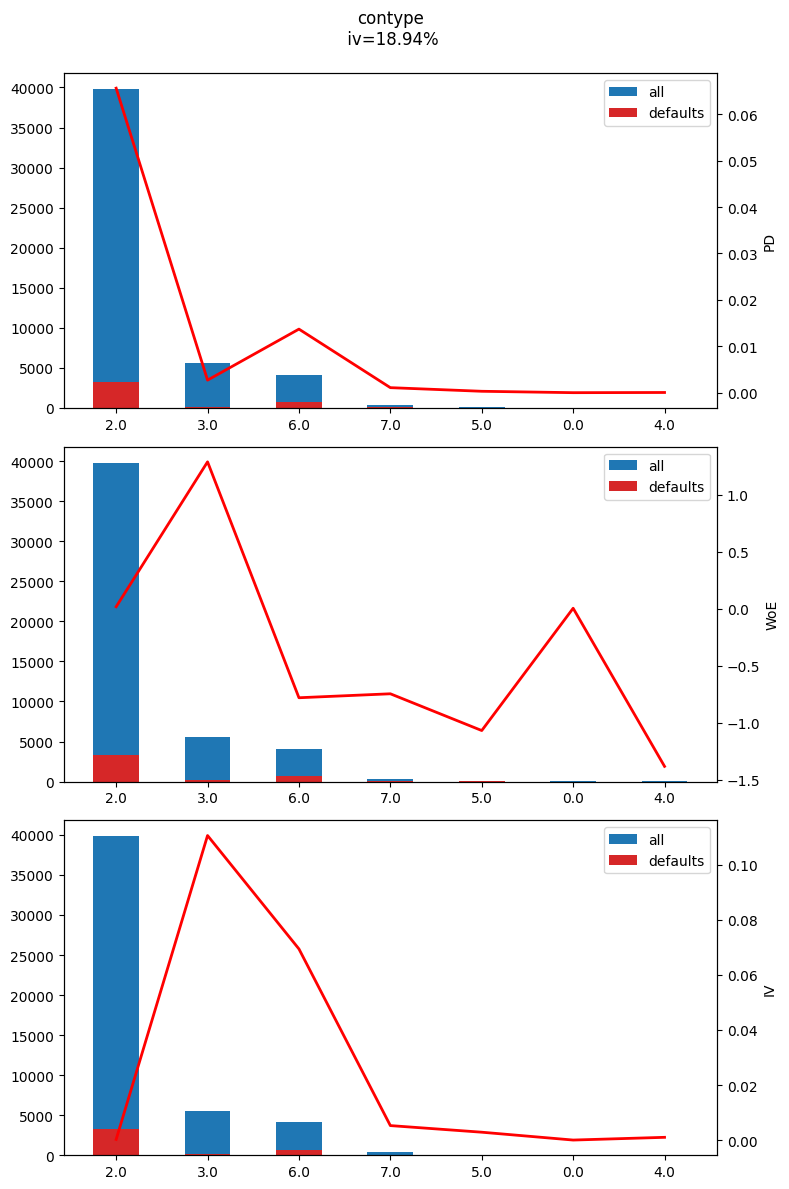

In [31]:
factor_name = 'contype'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

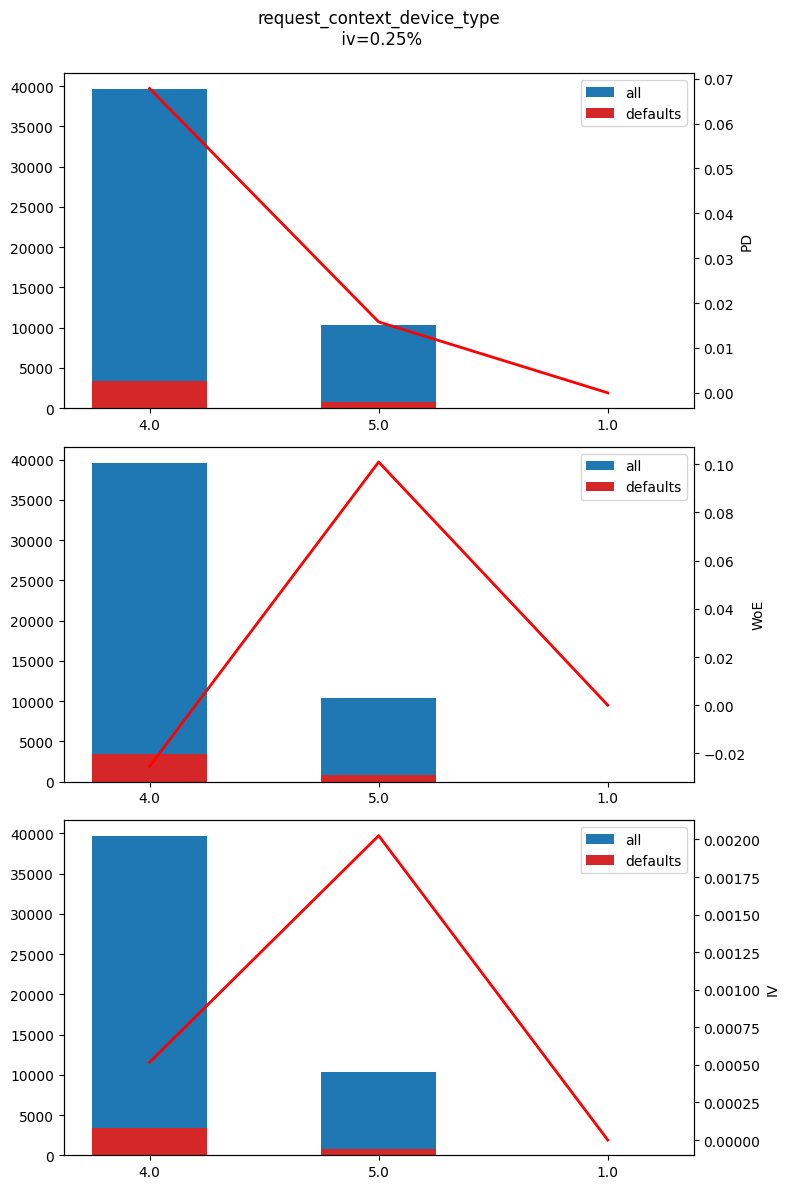

In [32]:
factor_name = 'request_context_device_type'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


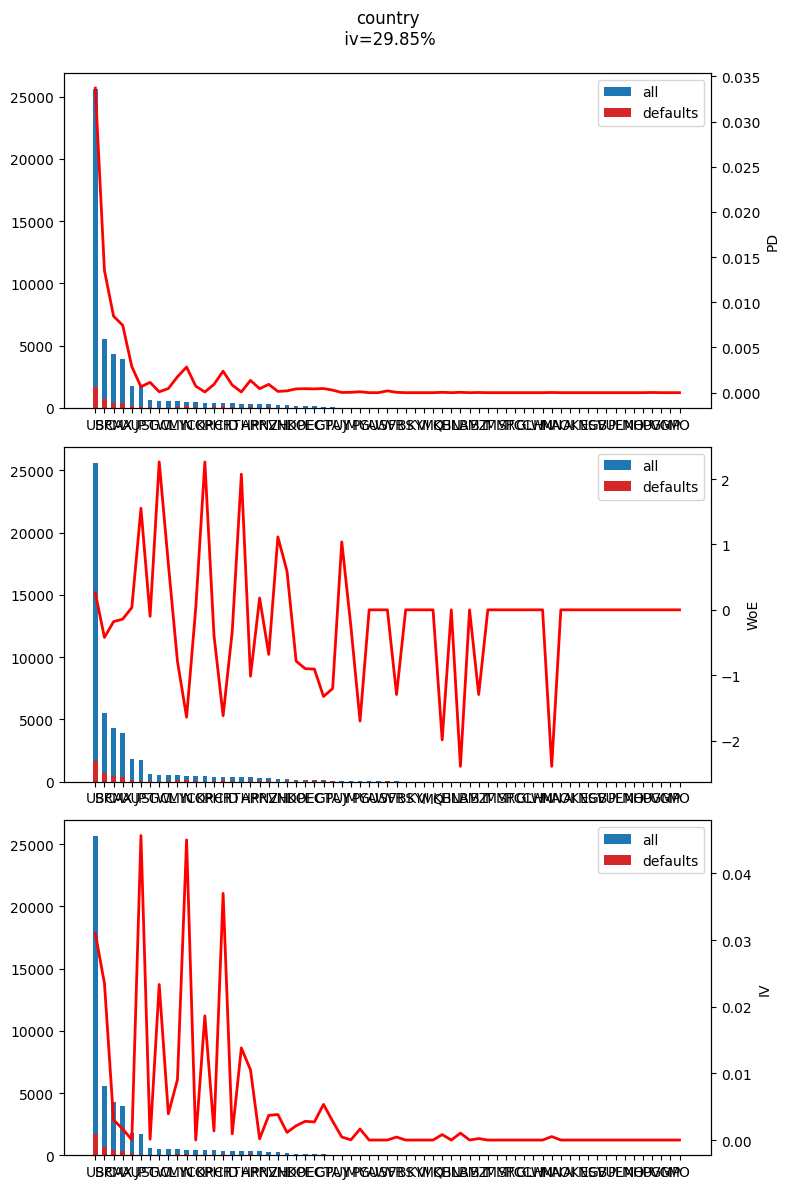

In [33]:
factor_name = 'country'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

In [34]:
df[0:40]

Value    All   Good   Bad  Distr_Good  Distr_Bad   WoE    IV   PD  \
2     US  25623  23938  1685        0.52       0.40  0.26  0.03 0.03   
4     BR   5533   4857   676        0.11       0.16 -0.42  0.02 0.01   
3     CA   4293   3870   423        0.08       0.10 -0.18  0.00 0.01   
0     MX   3921   3548   373        0.08       0.09 -0.14  0.00 0.01   
5     AU   1777   1633   144        0.04       0.03  0.03  0.00 0.00   
8     JP   1742   1709    33        0.04       0.01  1.55  0.05 0.00   
9     SG    623    566    57        0.01       0.01 -0.10  0.00 0.00   
10    TW    532    527     5        0.01       0.00  2.26  0.02 0.00   
7     CL    532    509    23        0.01       0.01  0.70  0.00 0.00   
17    MY    526    438    88        0.01       0.02 -0.79  0.01 0.00   
11    IN    443    301   142        0.01       0.03 -1.64  0.05 0.00   
1     CO    440    404    36        0.01       0.01  0.02  0.00 0.00   
18    KR    425    421     4        0.01       0.00  2.26  0.02 0.00   
19    PH    388    342    46        0.01       0.01 -0.39  0.00 0.00   
6     CR    377    258   119        0.01       0.03 -1.62  0.04 0.00   
21    ID    373    331    42        0.01       0.01 -0.33  0.00 0.00   
20    TH    353    349     4        0.01       0.00  2.07  0.01 0.00   
12    AR    338    270    68        0.01       0.02 -1.02  0.01 0.00   
22    PR    311    289    22        0.01       0.01  0.18  0.00 0.00   
23    NZ    301    255    46        0.01       0.01 -0.68  0.00 0.00   
13    VN    241    234     7        0.01       0.00  1.12  0.00 0.00   
16    HK    208    198    10        0.00       0.00  0.59  0.00 0.00   
25    DO    126    105    21        0.00       0.01 -0.78  0.00 0.00   
14    PE    120     98    22        0.00       0.01 -0.90  0.00 0.00   
15    EC    114     93    21        0.00       0.01 -0.91  0.00 0.00   
30    GT     90     67    23        0.00       0.01 -1.32  0.01 0.00   
29    PA     60     46    14        0.00       0.00 -1.20  0.00 0.00   
37    UY     32     31     1        0.00       0.00  1.04  0.00 0.00   
24    JM     19     17     2        0.00       0.00 -0.25  0.00 0.00   
31    PY     15     10     5        0.00       0.00 -1.70  0.00 0.00   
28    GU     11     11     0        0.00       0.00  0.00  0.00 0.00   
43    AW     11     11     0        0.00       0.00  0.00  0.00 0.00   
45    SV     10      0    10        0.00       0.00  0.00 -0.00 0.00   
27    FR      8      6     2        0.00       0.00 -1.30  0.00 0.00   
32    BS      7      7     0        0.00       0.00  0.00  0.00 0.00   
33    KY      6      6     0        0.00       0.00  0.00  0.00 0.00   
51    VI      6      6     0        0.00       0.00  0.00  0.00 0.00   
50    MQ      5      5     0        0.00       0.00  0.00  0.00 0.00   
42    KH      5      3     2        0.00       0.00 -1.99  0.00 0.00   
36    BN      5      5     0        0.00       0.00  0.00  0.00 0.00   

    All_proc  All_cumm  All_cumm_proc  
2       0.51     25623           0.51  
4       0.11     31156           0.62  
3       0.09     35449           0.71  
0       0.08     39370           0.79  
5       0.04     41147           0.82  
8       0.03     42889           0.86  
9       0.01     43512           0.87  
10      0.01     44044           0.88  
7       0.01     44576           0.89  
17      0.01     45102           0.90  
11      0.01     45545           0.91  
1       0.01     45985           0.92  
18      0.01     46410           0.93  
19      0.01     46798           0.94  
6       0.01     47175           0.94  
21      0.01     47548           0.95  
20      0.01     47901           0.96  
12      0.01     48239           0.96  
22      0.01     48550           0.97  
23      0.01     48851           0.98  
13      0.00     49092           0.98  
16      0.00     49300           0.99  
25      0.00     49426           0.99  
14      0.00     49546           0.99  
15      0.00     49660           0.99  
30      0.

In [35]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["US", "BR", "CA", "MX", "JP", "AU"]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['country_grouped'] = data['country'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['country_grouped'] = data_test['country'].apply(lambda x: map_dict.get(x, default_value))

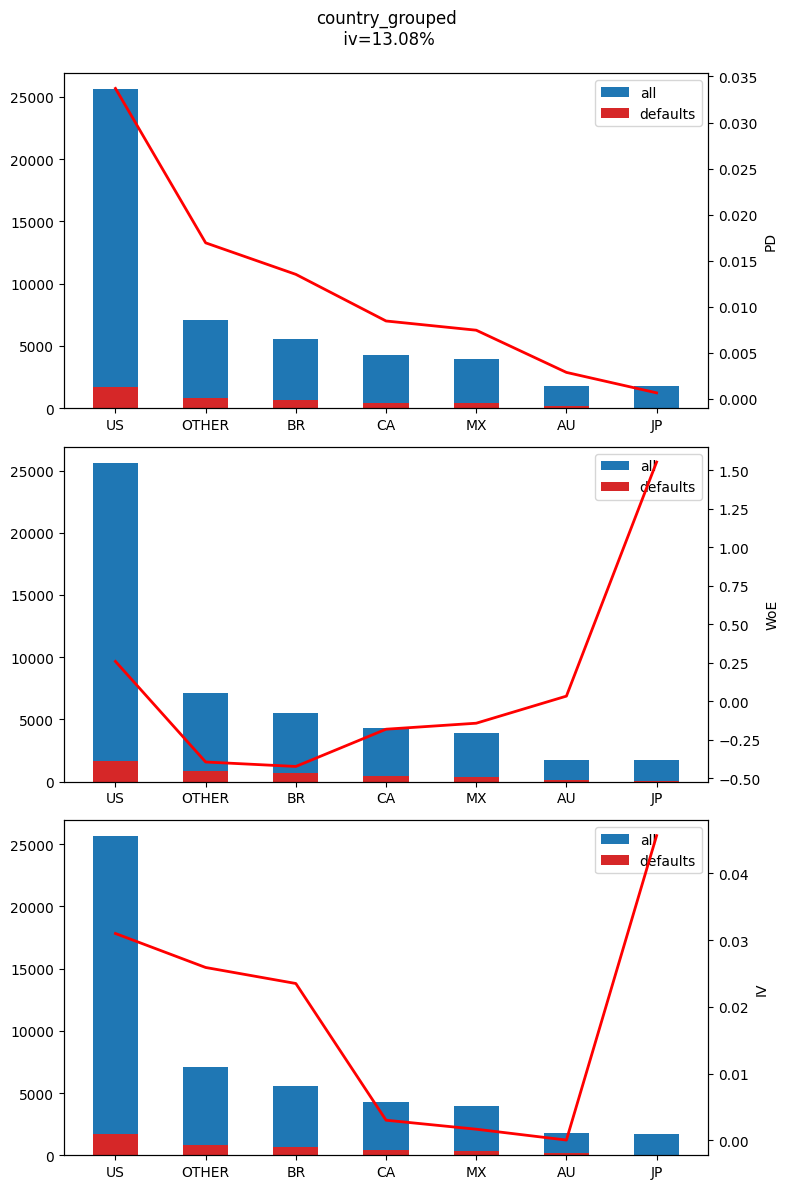

In [36]:
factor_name = 'country_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


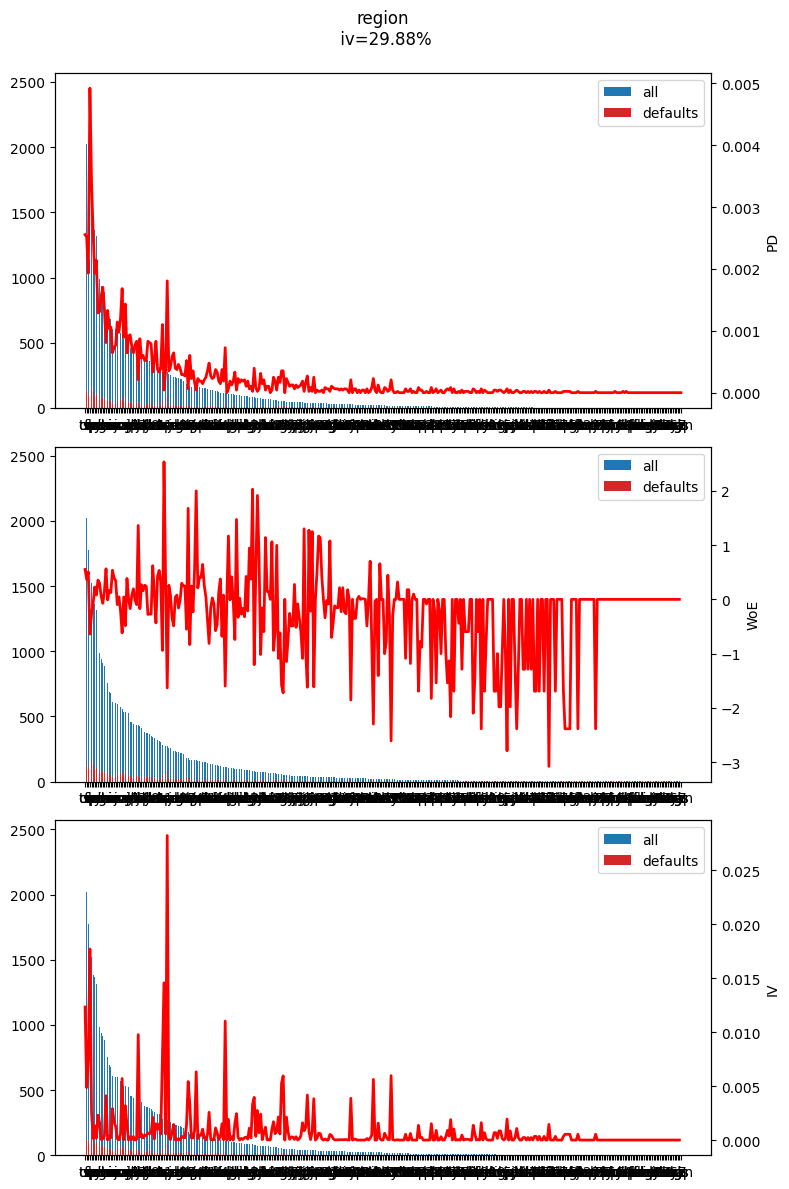

In [37]:
factor_name = 'region'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

In [38]:
df[0:20]

Value   All  Good  Bad  Distr_Good  Distr_Bad   WoE   IV   PD  All_proc  \
20    tx  2447  2324  123        0.05       0.03  0.55 0.01 0.00      0.05   
4     ca  2022  1901  121        0.04       0.03  0.37 0.00 0.00      0.04   
18    fl  1775  1682   93        0.04       0.02  0.51 0.01 0.00      0.04   
12    sp  1597  1360  237        0.03       0.06 -0.64 0.02 0.00      0.03   
6     qc  1524  1360  164        0.03       0.04 -0.27 0.00 0.00      0.03   
33    on  1380  1256  124        0.03       0.03 -0.07 0.00 0.00      0.03   
55    ny  1364  1271   93        0.03       0.02  0.23 0.00 0.00      0.03   
16    pa  1317  1214  103        0.03       0.03  0.08 0.00 0.00      0.03   
14    oh  1024   962   62        0.02       0.02  0.35 0.00 0.00      0.02   
86    nc   987   924   63        0.02       0.02  0.30 0.00 0.00      0.02   
17    il   937   862   75        0.02       0.02  0.05 0.00 0.00      0.02   
36   cmx   912   830   82        0.02       0.02 -0.07 0.00 0.00      0.02   
9     mi   888   823   65        0.02       0.02  0.15 0.00 0.00      0.02   
31    ga   785   746   39        0.02       0.01  0.56 0.00 0.00      0.02   
37    tn   754   690   64        0.02       0.02 -0.01 0.00 0.00      0.02   
51    wa   690   640   50        0.01       0.01  0.16 0.00 0.00      0.01   
66    va   680   629   51        0.01       0.01  0.13 0.00 0.00      0.01   
21    nj   608   577   31        0.01       0.01  0.54 0.00 0.00      0.01   
43    in   603   568   35        0.01       0.01  0.40 0.00 0.00      0.01   
58    mo   603   566   37        0.01       0.01  0.34 0.00 0.00      0.01   

    All_cumm  All_cumm_proc  
20      2447           0.05  
4       4469           0.09  
18      6244           0.13  
12      7841           0.16  
6       9365           0.19  
33     10745           0.22  
55     12109           0.25  
16     13426           0.28  
14     14450           0.30  
86     15437           0.32  
17     16374           0.34  
36     17286           0.36  
9      18174           0.38  
31     18959           0.39  
37     19713           0.41  
51     20403           0.42  
66     21083           0.44  
21     21691           0.45  
43     22294           0.46  
58     22897           0.48

In [39]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["tx", "ca", "fl", "sp"]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['region_grouped'] = data['region'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['region_grouped'] = data_test['region'].apply(lambda x: map_dict.get(x, default_value))

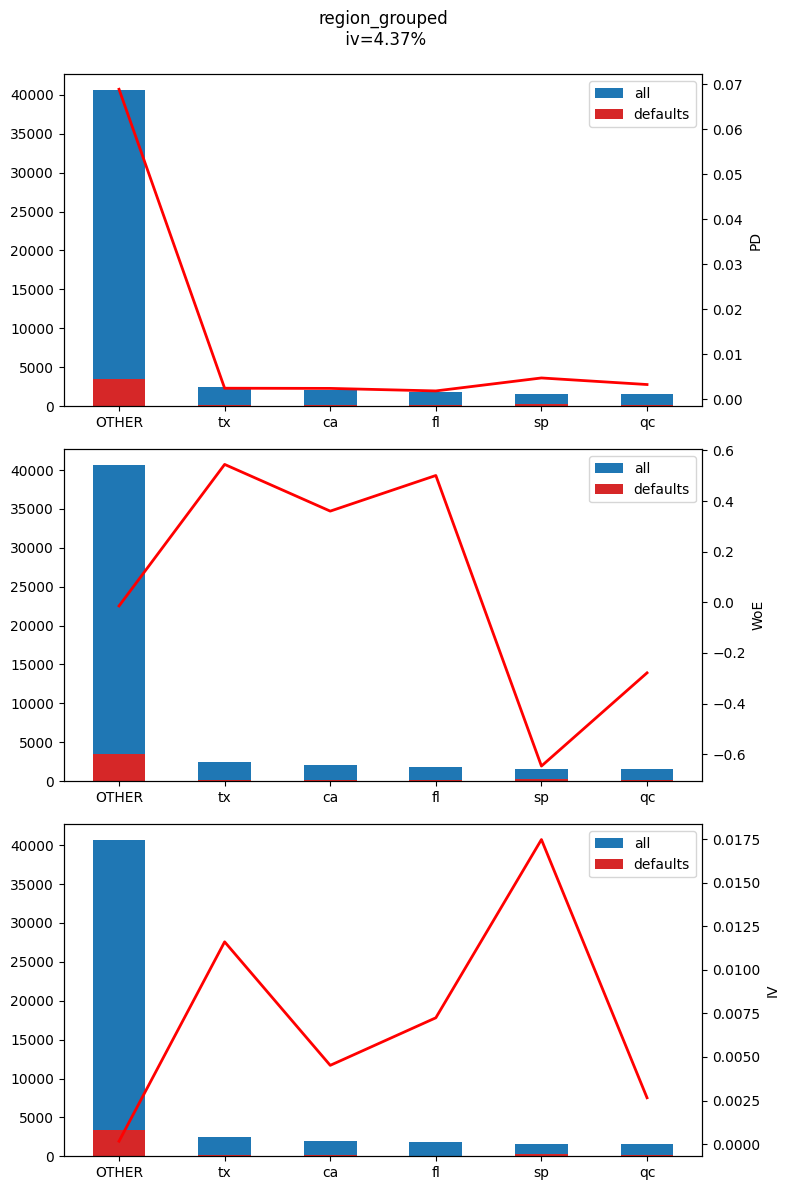

In [40]:
factor_name = 'region_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


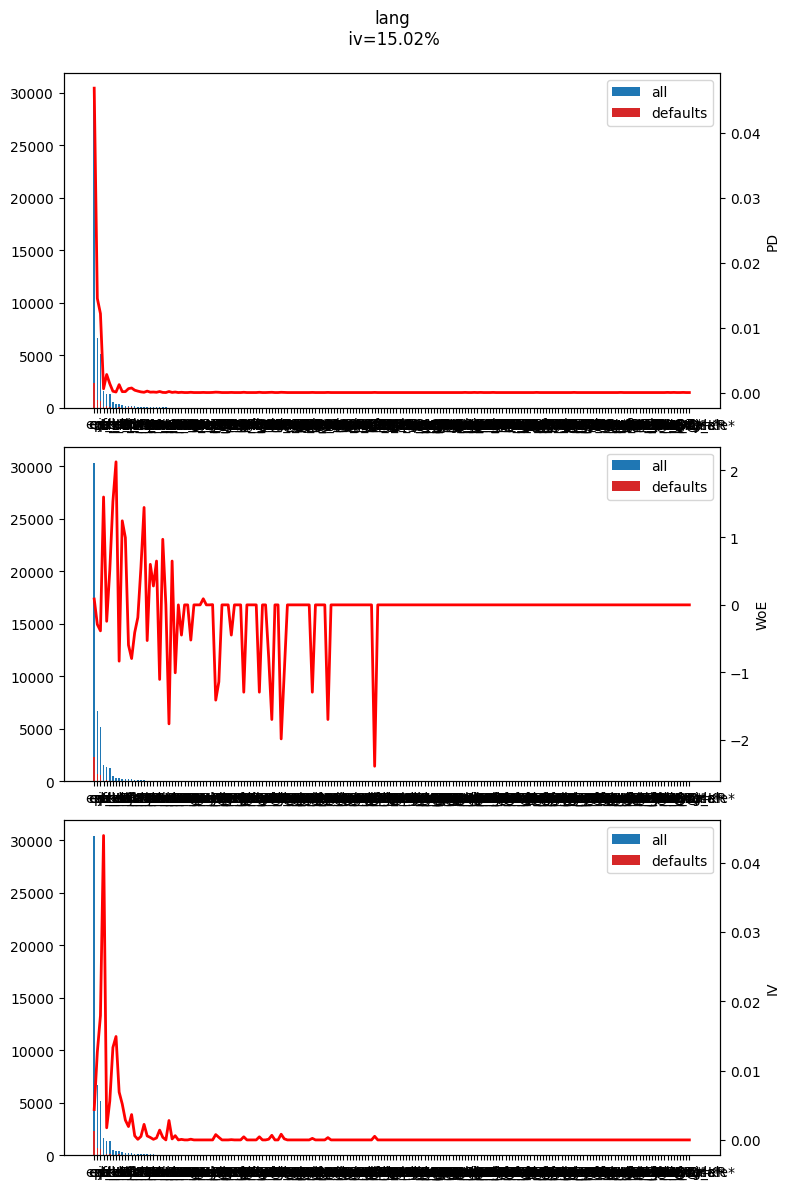

In [41]:
factor_name = 'lang'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

In [42]:
df[0:20]

Value    All   Good   Bad  Distr_Good  Distr_Bad   WoE   IV   PD  \
1            en  30366  28021  2345        0.61       0.56  0.09 0.00 0.05   
0            es   6668   5943   725        0.13       0.17 -0.29 0.01 0.01   
4            pt   5140   4532   608        0.10       0.15 -0.39 0.02 0.01   
7            ja   1604   1575    29        0.03       0.01  1.60 0.04 0.00   
3            fr   1333   1194   139        0.03       0.03 -0.24 0.00 0.00   
2         en_US   1314   1246    68        0.03       0.02  0.51 0.01 0.00   
8            zh    518    508    10        0.01       0.00  1.53 0.01 0.00   
13           ko    370    366     4        0.01       0.00  2.12 0.01 0.00   
5         pt_BR    351    290    61        0.01       0.01 -0.84 0.01 0.00   
17           th    274    267     7        0.01       0.00  1.25 0.01 0.00   
10           vi    215    208     7        0.00       0.00  1.00 0.00 0.00   
12        es_US    211    181    30        0.00       0.01 -0.60 0.00 0.00   
15           id    208    173    35        0.00       0.01 -0.80 0.00 0.00   
6         en_CA    149    131    18        0.00       0.00 -0.41 0.00 0.00   
16        es_MX    111    100    11        0.00       0.00 -0.19 0.00 0.00   
29  zh_HK_#Hant    101     96     5        0.00       0.00  0.56 0.00 0.00   
26        ja_JP     95     93     2        0.00       0.00  1.45 0.00 0.00   
24        fr_CA     82     71    11        0.00       0.00 -0.53 0.00 0.00   
23  zh_TW_#Hant     63     60     3        0.00       0.00  0.60 0.00 0.00   
32        en_AU     62     58     4        0.00       0.00  0.28 0.00 0.00   

    All_proc  All_cumm  All_cumm_proc  
1       0.61     30366           0.61  
0       0.13     37034           0.74  
4       0.10     42174           0.84  
7       0.03     43778           0.88  
3       0.03     45111           0.90  
2       0.03     46425           0.93  
8       0.01     46943           0.94  
13      0.01     47313           0.95  
5       0.01     47664           0.95  
17      0.01     47938           0.96  
10      0.00     48153           0.96  
12      0.00     48364           0.97  
15      0.00     48572           0.97  
6       0.00     48721           0.97  
16      0.00     48832           0.98  
29      0.00     48933           0.98  
26      0.00     49028           0.98  
24      0.00     49110           0.98  
23      0.00     49173           0.98  
32      0.00     49235           0.98

In [43]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["en", "es", "pt", "ja"]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['lang_grouped'] = data['lang'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['lang_grouped'] = data_test['lang'].apply(lambda x: map_dict.get(x, default_value))

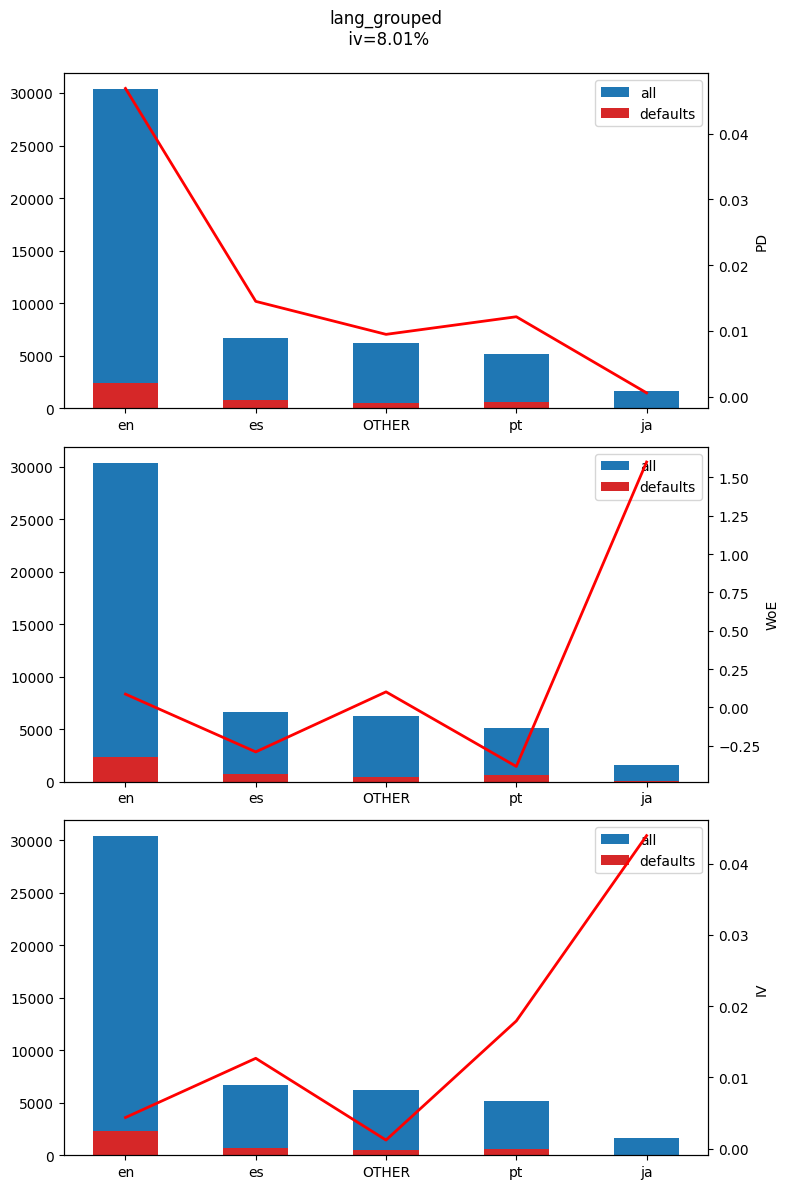

In [44]:
factor_name = 'lang_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

In [45]:
data['lang'].unique()

array(['es', 'en', 'en_US', 'fr', 'pt', 'pt_BR', 'en_CA', 'ja', 'zh',
       'es_US_#u-mu-celsius', 'vi', 'hu', 'es_US', 'ko', 'ru', 'id',
       'es_MX', 'th', 'de', 'zh-Hans_US', 'en_ID', 'es_001@rg=uszzzz',
       'es_PE', 'zh_TW_#Hant', 'fr_CA', 'en_US@calendar=buddhist',
       'ja_JP', 'fr_US', 'pt_PT', 'zh_HK_#Hant', 'en_001@rg=uazzzz',
       'es_AR', 'en_AU', 'es_CL', 'ms', 'zh_SG_#Hans',
       'th_US@calendar=buddhist', 'uk', 'zh-Hans_MY', 'yue', 'es_CR',
       'es_MX@calendar=buddhist', 'zh_TW', 'es_CO', 'es_ES@rg=clzzzz',
       'id_ID', 'zh-Hant_US', 'en_GB', 'th_TH@calendar=gregorian',
       'en_IN', 'ko-Kore_KR', 'en_US@rg=auzzzz', 'en_GB@rg=idzzzz',
       'en_GB@rg=auzzzz', 'en_AU@rg=uszzzz', 'zh_CN_#Hans', 'sv',
       'en_IR@calendar=gregorian', 'es_PA', 'es_EC', 'en_MY', 'en_BR',
       'en_JP@calendar=japanese', 'es_GT', 'zh-Hans_MY@calendar=buddhist',
       'en_AU@rg=myzzzz', 'vi_VN', 'th_TH', 'ko_KR', 'en_SG',
       'en_IE@rg=nzzzzz', 'es_001@rg=cozzzz', 'zh

Create a new feature by refining only the first letters before the underscore

In [46]:
data['lang2'] = data['lang'].apply(lambda x: x.split('_')[0].split('-')[0])
data_test['lang2'] = data_test['lang'].apply(lambda x: x.split('_')[0].split('-')[0])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


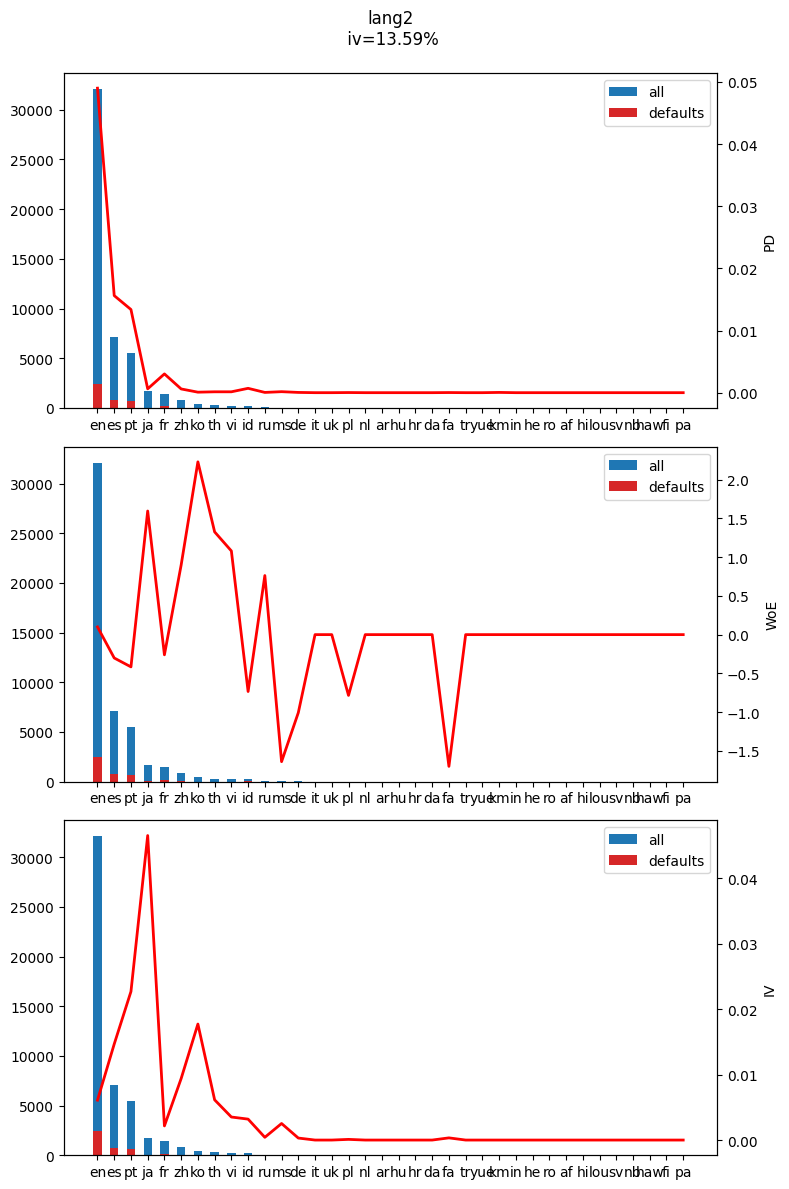

In [47]:
factor_name = 'lang2'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

In [48]:
df

Value    All   Good   Bad  Distr_Good  Distr_Bad   WoE    IV   PD  \
1     en  32107  29657  2450        0.65       0.59  0.10  0.01 0.05   
0     es   7111   6330   781        0.14       0.19 -0.30  0.01 0.02   
3     pt   5503   4834   669        0.11       0.16 -0.42  0.02 0.01   
4     ja   1707   1676    31        0.04       0.01  1.60  0.05 0.00   
2     fr   1426   1275   151        0.03       0.04 -0.26  0.00 0.00   
5     zh    838    808    30        0.02       0.01  0.90  0.01 0.00   
8     ko    412    408     4        0.01       0.00  2.23  0.02 0.00   
11    th    296    289     7        0.01       0.00  1.33  0.01 0.00   
6     vi    233    226     7        0.00       0.00  1.08  0.00 0.00   
10    id    219    184    35        0.00       0.01 -0.73  0.00 0.00   
9     ru     49     47     2        0.00       0.00  0.76  0.00 0.00   
13    ms     25     17     8        0.00       0.00 -1.64  0.00 0.00   
12    de     10      8     2        0.00       0.00 -1.01  0.00 0.00   
26    it      8      8     0        0.00       0.00  0.00  0.00 0.00   
14    uk      8      8     0        0.00       0.00  0.00  0.00 0.00   
18    pl      6      5     1        0.00       0.00 -0.78  0.00 0.00   
21    nl      5      5     0        0.00       0.00  0.00  0.00 0.00   
19    ar      4      4     0        0.00       0.00  0.00  0.00 0.00   
7     hu      3      3     0        0.00       0.00  0.00  0.00 0.00   
31    hr      3      3     0        0.00       0.00  0.00  0.00 0.00   
22    da      3      3     0        0.00       0.00  0.00  0.00 0.00   
23    fa      3      2     1        0.00       0.00 -1.70  0.00 0.00   
17    tr      3      3     0        0.00       0.00  0.00  0.00 0.00   
15   yue      2      2     0        0.00       0.00  0.00  0.00 0.00   
20    km      2      0     2        0.00       0.00  0.00 -0.00 0.00   
24    in      2      2     0        0.00       0.00  0.00  0.00 0.00   
27    he      2      2     0        0.00       0.00  0.00  0.00 0.00   
28    ro      2      2     0        0.00       0.00  0.00  0.00 0.00   
34    af      1      1     0        0.00       0.00  0.00  0.00 0.00   
33    hi      1      1     0        0.00       0.00  0.00  0.00 0.00   
32   lou      1      1     0        0.00       0.00  0.00  0.00 0.00   
16    sv      1      1     0        0.00       0.00  0.00  0.00 0.00   
30    nb      1      1     0        0.00       0.00  0.00  0.00 0.00   
29   haw      1      1     0        0.00       0.00  0.00  0.00 0.00   
25    fi      1      1     0        0.00       0.00  0.00  0.00 0.00   
35    pa      1      1     0        0.00       0.00  0.00  0.00 0.00   

    All_proc  All_cumm  All_cumm_proc  
1       0.64     32107           0.64  
0       0.14     39218           0.78  
3       0.11     44721           0.89  
4       0.03     46428           0.93  
2       0.03     47854           0.96  
5       0.02     48692           0.97  
8       0.01     49104           0.98  
11      0.01     49400           0.99  
6       0.00     49633           0.99  
10      0.00     49852           1.00  
9       0.00     49901           1.00  
13      0.00     49926           1.00  
12      0.00     49936           1.00  
26      0.00     49944           1.00  
14      0.00     49952           1.00  
18      0.00     49958           1.00  
21      0.00     49963           1.00  
19      0.00     49967           1.00  
7       0.00     49970           1.00  
31      0.00     49973           1.00  
22      0.00     49976           1.00  
23      0.00     49979           1.00  
17      0.00     49982           1.00  
15      0.00     49984           1.00  
20      0.00     49986           1.00  
24      0.00     49988           1.00  
27      0.00     49990           1.00  
28      0.00     49992           1.00  
34      0.00     49993           1.00  
33      0.00     49994           1.00  
32      0.00     49995           1.00  
16      0.00     49996           1.00  
30      0.00     4

In [49]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["en", "es", "pt", "ja"]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['lang2_grouped'] = data['lang2'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['lang2_grouped'] = data_test['lang2'].apply(lambda x: map_dict.get(x, default_value))

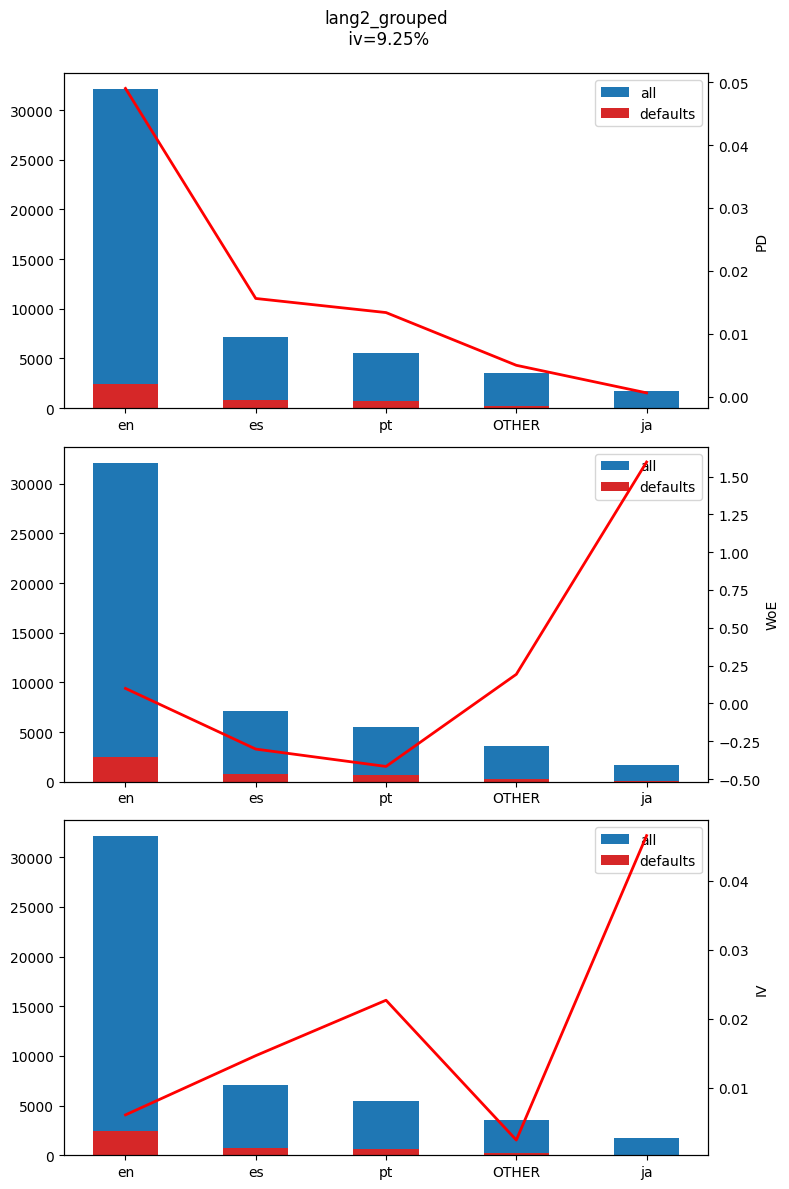

In [50]:
factor_name = 'lang2_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

There is minimal difference between the original 'lang' feature and the refined version. Therefore, we will keep only the 'lang' feature

In [51]:
to_delete_features = ['ssp','sdk','adt', 'dc',  'ifa']

numeric_logistic_features = ['flr_logistic', 'sellerClearPrice_logistic', 'request_context_device_w_logistic', 'request_context_device_h_logistic', 'price_logistic']
time_cos_sin_features = ['hour_cos', 'hour_sin']
categoric_woe_features = [ 'dsp_grouped_woe', 'auctionBidFloorSource_woe',  'sdkver_grouped_woe', 'bundle_woe',
                          'os_woe',  'bidderFlrPolicy_woe','contype_woe', 'request_context_device_type_woe',
                           'country_grouped', 'region_grouped', 'lang_grouped']

features_selected = numeric_logistic_features + time_cos_sin_features + categoric_woe_features

In [52]:
lst = []

IV_df = pd.DataFrame(columns=['Variable','IV'])
for col in categoric_woe_features:
    df, iv = factor_utils.calculate_woe_iv(data, col, target_feature)

    lst.append(df)
    IV_df = pd.concat([IV_df, pd.DataFrame([{
                "Variable" :col ,
                "IV" : iv,
                }])], ignore_index=True)
   # IV_df = IV_df.append({
    #            "Variable" :col ,
    #            "IV" : iv,
    #            },ignore_index=True)

<ipython-input-52-e306358ce6f6>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  IV_df = pd.concat([IV_df, pd.DataFrame([{


In [53]:
IV_df

Variable   IV
0                   dsp_grouped_woe 2.10
1         auctionBidFloorSource_woe 0.73
2                sdkver_grouped_woe 1.23
3                        bundle_woe 1.34
4                            os_woe 1.31
5               bidderFlrPolicy_woe 0.01
6                       contype_woe 0.19
7   request_context_device_type_woe 0.00
8                   country_grouped 0.13
9                    region_grouped 0.04
10                     lang_grouped 0.08

### We can choose all categorical variables except two variables with the lowest IV

In [54]:
categoric_features_selected = ['dsp_grouped_woe',
 'auctionBidFloorSource_woe',
 'sdkver_grouped_woe',
 'bundle_woe',
 'os_woe',

 'contype_woe',

 'country_grouped_woe',
 'region_grouped_woe',
 'lang_grouped_woe']

In [56]:
for feature_name in categoric_features_selected:
   data[feature_name] = data[feature_name].astype("object")

#test
   data_test[feature_name] = data_test[feature_name].astype("object")

In [57]:
features_selected = numeric_features_selected +  categoric_features_selected
features_selected

['flr_logistic',
 'sellerClearPrice_logistic',
 'request_context_device_w_logistic',
 'request_context_device_h_logistic',
 'price_logistic',
 'dsp_grouped_woe',
 'auctionBidFloorSource_woe',
 'sdkver_grouped_woe',
 'bundle_woe',
 'os_woe',
 'contype_woe',
 'country_grouped_woe',
 'region_grouped_woe',
 'lang_grouped_woe']

### Refining the dataset by deleting unselected features

In [58]:
all_columns = features_selected + [target_feature]
all_columns
data = data[all_columns]

#test
data_test = data_test[all_columns]

## 📈 How  features correlate with the target variable?

In [59]:
data.corr()[target_feature].drop(target_feature).sort_values().hvplot.barh(
    width=600, height=400,
    title="Correlation between Target and Numeric Features",
    ylabel='Correlation', xlabel='Numerical Features',
)

:Bars   [index]   (target)

<Axes: >

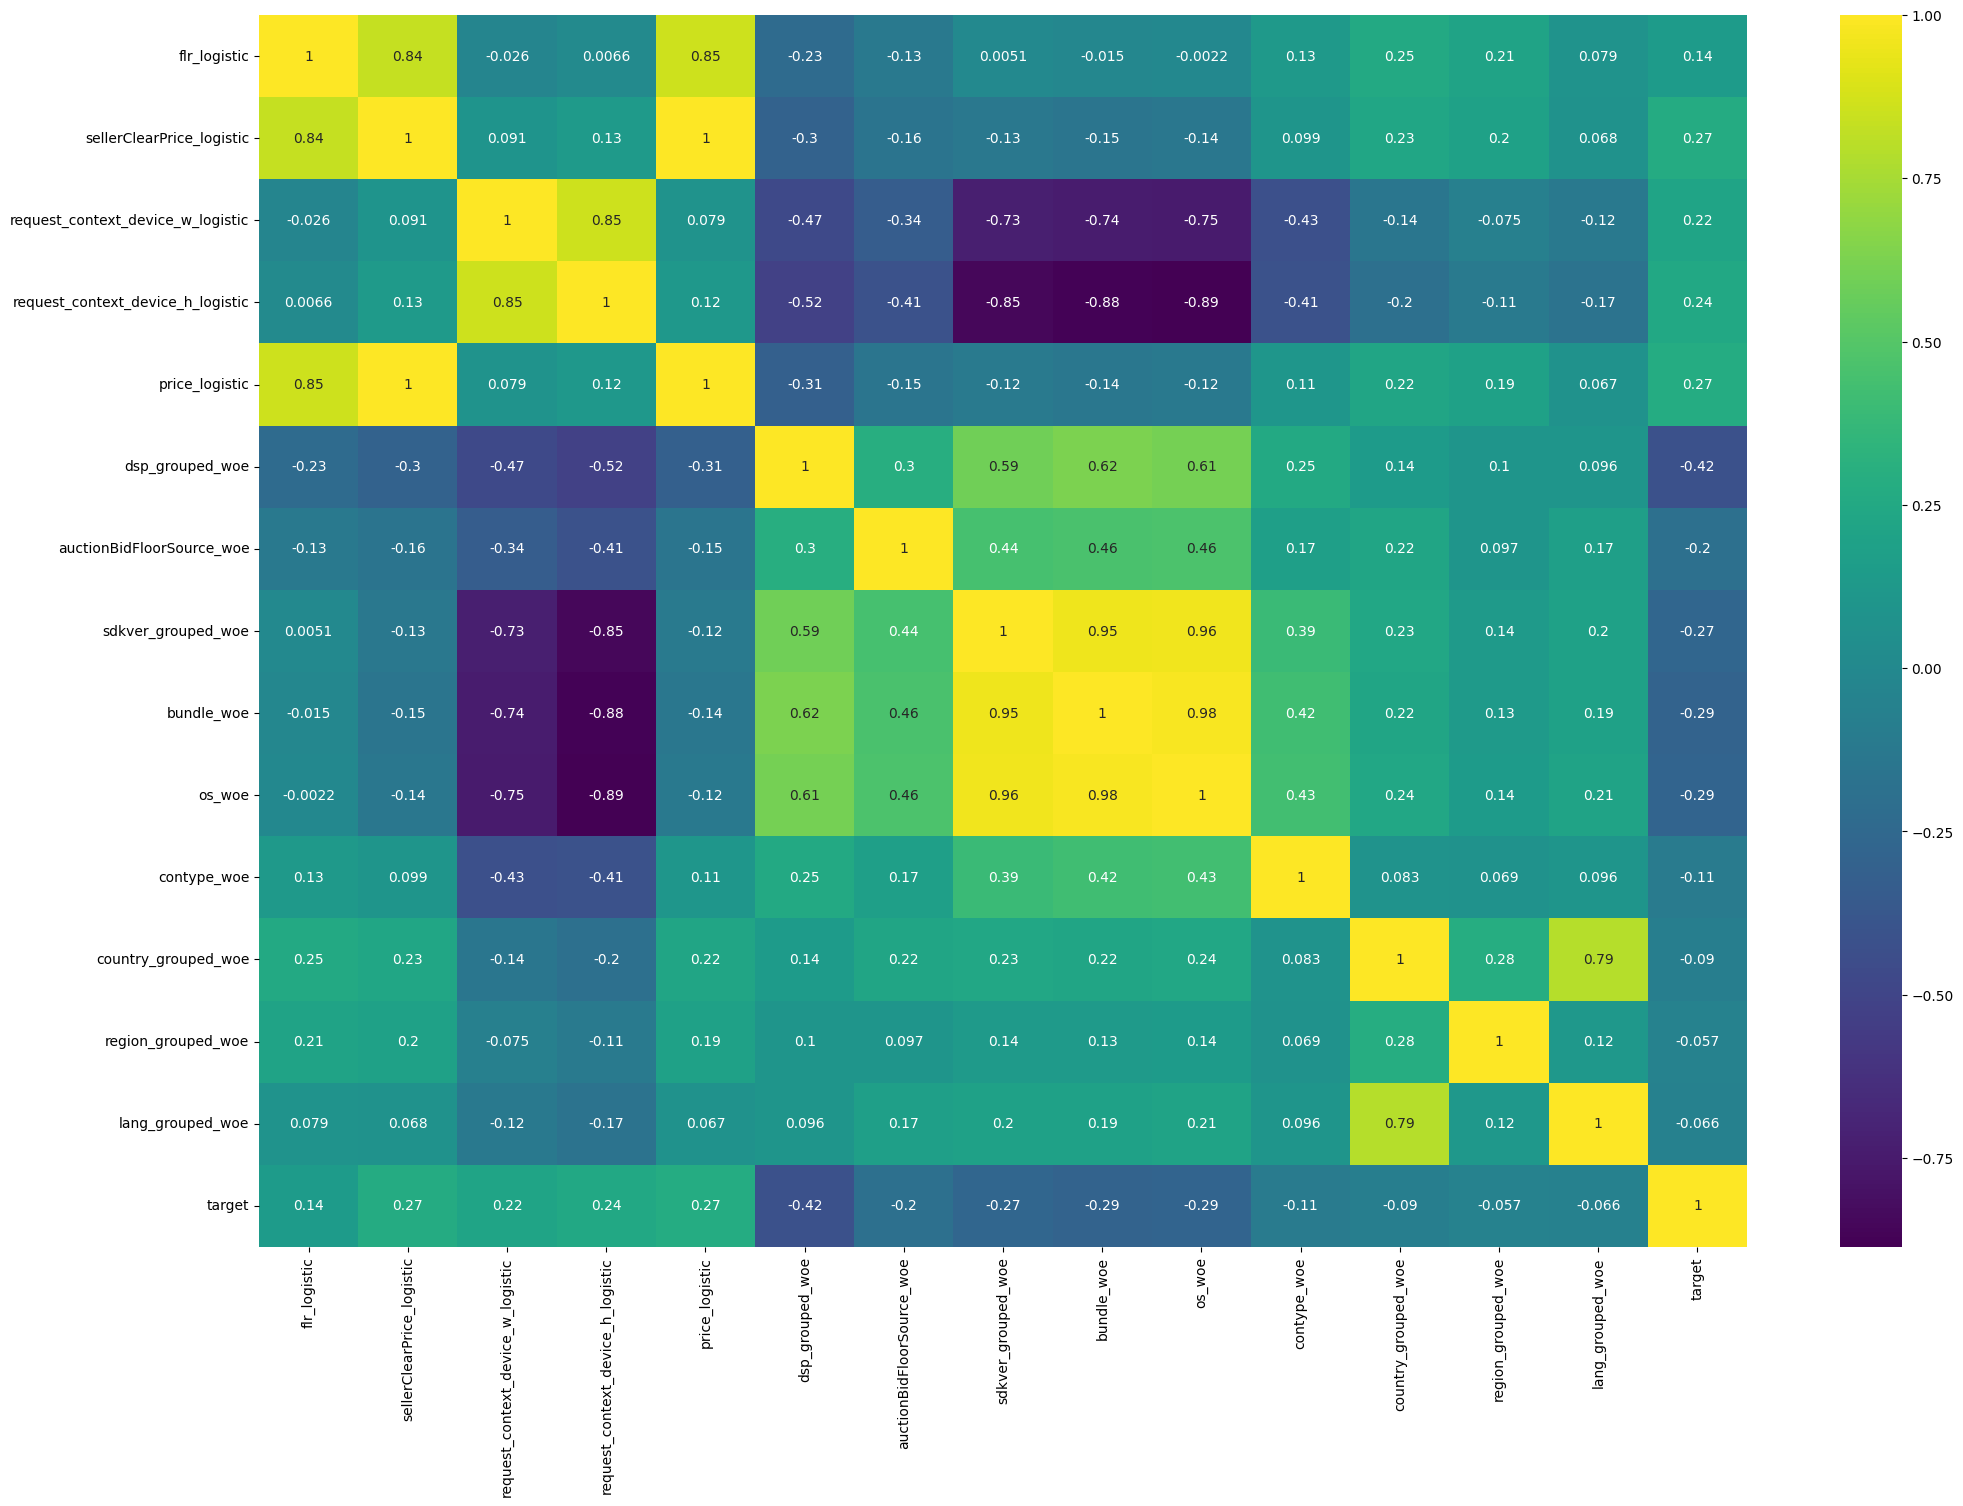

In [60]:
plt.figure(figsize=(24, 16))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

****

****

# Outliers Detection and Removing

In [75]:
## We need to remove outliers found in the analysis

# 🔄 Data PreProcessing

**Section Goals:**
> - Remove or fill any missing data.
> - Remove unnecessary or repetitive features.
> - Convert categorical string features to dummy variables.

In [61]:
# The length of the data
print(f"The Length of the data: {data.shape}")

The Length of the data: (50000, 15)


In [62]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

### NA detection

In [63]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

In [79]:
#data.dropna(inplace=True)

## 🧮 Categorical Variables and Dummy Variables

In [64]:
print([column for column in data.columns if data[column].dtype == object])

['dsp_grouped_woe', 'auctionBidFloorSource_woe', 'sdkver_grouped_woe', 'bundle_woe', 'os_woe', 'contype_woe', 'country_grouped_woe', 'region_grouped_woe', 'lang_grouped_woe']


We can assess the necessity of dummy variables later if the WoE variables are not sufficient. For now, we will not introduce any dummy variables.

In [81]:
#dummies = ['']
#data = pd.get_dummies(data, columns=dummies, drop_first=True)

## 🔪 Train Test Split

In [65]:
w_p = data[target_feature].value_counts()[0] / data.shape[0]
w_n = data[target_feature].value_counts()[1] / data.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")

Weight of positive values 0.91638
Weight of negative values 0.08362


In [66]:
features_selected

['flr_logistic',
 'sellerClearPrice_logistic',
 'request_context_device_w_logistic',
 'request_context_device_h_logistic',
 'price_logistic',
 'dsp_grouped_woe',
 'auctionBidFloorSource_woe',
 'sdkver_grouped_woe',
 'bundle_woe',
 'os_woe',
 'contype_woe',
 'country_grouped_woe',
 'region_grouped_woe',
 'lang_grouped_woe']

In [67]:
features_selected_and_target = features_selected + [target_feature]

train = data
test = data_test
#train, test = train_test_split(data[features_selected_and_target], test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

(50000, 15)
(1500000, 15)


## 📏 Normalizing the data

We can, for example, apply Z-score normalization (standardization) or Min-Max normalization (scaling):

standardized_data = (data - data.mean()) / data.std()

normalized_data = (data - data.min()) / (data.max() - data.min())

However, for now, we will proceed with the raw data and evaluate the model performances.

In [68]:
X_train, y_train = train.drop(target_feature, axis=1), train[target_feature]
X_test, y_test = test.drop(target_feature, axis=1), test[target_feature]

# 🤖 Models Building

In [69]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)


#  ✔️ 1. Artificial Neural Networks (ANNs)

In [70]:

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [71]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [10, 10, 5]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model_ann = nn_model(
    num_columns=num_columns,
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)


In [74]:
we_are_learning = True

if we_are_learning:
  r = model_ann.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
  )
  model_ann.save('/content/drive/MyDrive/bin/ann_model.h5')
else:
  model_ann = tf.keras.models.load_model('/content/drive/MyDrive/bin/ann_model.h5')

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 92s 56ms/step - AUC: 0.7461 - loss: 0.4236 - val_AUC: 0.8678 - val_loss: 0.2510
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 57ms/step - AUC: 0.8740 - loss: 0.2062 - val_AUC: 0.8751 - val_loss: 0.2471
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 56ms/step - AUC: 0.8834 - loss: 0.2016 - val_AUC: 0.8753 - val_loss: 0.2474
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 47ms/step - AUC: 0.8855 - loss: 0.1975 - val_AUC: 0.8807 - val_loss: 0.2452
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 98s 57ms/step - AUC: 0.8914 - loss: 0.1946 - val_AUC: 0.8829 - val_loss: 0.2427
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - AUC: 0.8914 - loss: 0.1949 - val_AUC: 0.8844 - val_loss: 0.2415
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - AUC: 0.8915 - loss: 0.1931 - val_AUC: 0.8835 - val_loss: 0.2418
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 95s 55ms/step - AUC: 0.8939 - loss: 0.1938 - val_AUC: 0.8865 - val_loss: 0.2393
Epoch 9/20
1563/1563 

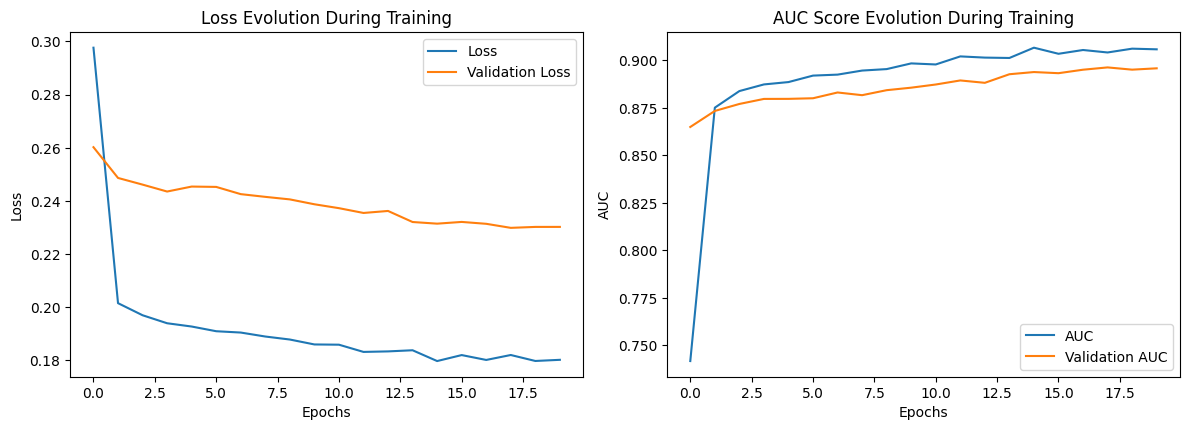

In [90]:
factor_utils.plot_learning_evolution(r)

In [75]:
# Predict probabilities for the test set
y_pred_prob = model_ann.predict(X_test)

# Initialize variables to store the best threshold and corresponding F1 score
best_threshold = 0
best_f1 = 0

# Define a list of possible threshold values between 0 and 1, incrementing by 0.01
thresholds = [i * 0.01 for i in range(1, 100)]

# Loop over each threshold to find the one that maximizes the F1 score
for threshold in thresholds:
    # Convert predicted probabilities into binary outcomes (0 or 1) using the current threshold
    y_pred = (y_pred_prob > threshold).astype(int)

    # Calculate the F1 score for this threshold
    f1 = f1_score(y_test, y_pred)

    # Update the best threshold and F1 score if the current F1 is higher
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Output the best threshold and corresponding F1 score
print(f'Best threshold: {best_threshold}, Best F1 score: {best_f1}')

46875/46875 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step
Best threshold: 0.31, Best F1 score: 0.5629723976424202


In [76]:
print(f'Best threshold: {best_threshold}, Best F1 score: {best_f1}')

Best threshold: 0.31, Best F1 score: 0.5629723976424202


In [78]:
we_want_to_preserve_probability_of_bid = False  # we_want_to_maximize_F1 = True

if we_want_to_preserve_probability_of_bid:
    # Step: Predict default probabilities on the training set
    y_train_proba_pred_ann = model_ann.predict(X_train)
    f1_ann, cutoff_ann, y_pred_train_ann = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_ann, verbose = True, text = "train")
    y_test_proba_pred_ann = model_ann.predict(X_test)
    f1_ann_test, _ , y_pred_test_ann= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_ann, cutoff_ann, verbose = True, text = "test")
else: # using <best_threshold>
    y_train_proba_pred_ann = model_ann.predict(X_train)
    f1_ann, _, y_pred_train_ann = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_ann, optimal_cutoff = best_threshold, verbose = True, text = "train")
    y_test_proba_pred_ann = model_ann.predict(X_test)
    f1_ann_test, _ , y_pred_test_ann= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_ann, best_threshold, verbose = True, text = "test")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
train
Optimal cutoff: 0.31
Accuracy: 0.92454
F1 Score: 0.5626521386345196
46875/46875 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step
test
Optimal cutoff: 0.31
Accuracy: 0.8851686666666667
F1 Score: 0.5629723976424202


In [79]:
factor_utils.print_score(y_test, y_pred_test_ann.round(), train=False)

Test Result:
Accuracy Score: 88.52%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0       1.0  accuracy  macro avg  weighted avg
precision       0.95      0.50      0.89       0.72          0.90
recall          0.92      0.65      0.89       0.78          0.89
f1-score        0.93      0.56      0.89       0.75          0.89
support   1329268.00 170732.00      0.89 1500000.00    1500000.00
_______________________________________________
Confusion Matrix: 
 [[1216810  112458]
 [  59789  110943]]

 F1 score: 56.30%
 Gini: 56.55%



In [80]:
scores_Gini_dict = {
    'ANNs': {
        'Train': 2 * roc_auc_score(y_train, y_train_proba_pred_ann) - 1,
        'Test': 2 * roc_auc_score(y_test, y_test_proba_pred_ann) - 1,
    },
}

scores_F1_dict = {
    'ANNs': {
        'Train': f1_ann,
        'Test': f1_ann_test,
    },
}

In [81]:
scores_Gini_dict

{'ANNs': {'Train': 0.8454433542955191, 'Test': 0.789030133988986}}

In [82]:
scores_F1_dict

{'ANNs': {'Train': 0.5626521386345196, 'Test': 0.5629723976424202}}

# ✔️ 2. XGBoost Classifier

In [83]:
xgb_clf = XGBClassifier(use_label_encoder=False)

In [84]:
we_are_learning = False

if we_are_learning:
    param_grid = dict(
      n_estimators=stats.randint(10, 500),
      max_depth=stats.randint(1, 10),
      learning_rate=stats.uniform(0, 1))

    xgb_cv = RandomizedSearchCV(
      xgb_clf, param_grid, cv=3, n_iter=60,
      scoring='roc_auc', n_jobs=-1, verbose=1)

    xgb_cv.fit(X_train, y_train)
    best_params = xgb_cv.best_params_
else:
    best_params = {'learning_rate': 0.17219709930788796, 'max_depth': 3, 'n_estimators': 168}

print(f"Best Parameters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)


Best Parameters: {'learning_rate': 0.17219709930788796, 'max_depth': 3, 'n_estimators': 168}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17219709930788796,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=168, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [85]:
y_train_proba_pred_xgb = xgb_clf.predict_proba(X_train)[:, 1]
f1_train_xgb, cutoff_xgb, y_pred_train_xgb = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_xgb, verbose = True, text = "train")
y_test_proba_pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]
f1_test_xgb, _ , y_pred_test_xgb= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_xgb, cutoff_xgb, verbose = True, text = "test")

train
Optimal cutoff: 0.3687519431114197
Accuracy: 0.93524
F1 Score: 0.6127720640994977
test
Optimal cutoff: 0.3687519431114197
Accuracy: 0.8969173333333333
F1 Score: 0.5891702314212078


In [86]:
factor_utils.print_score(y_train, y_pred_train_xgb, train = True)
factor_utils.print_score(y_test, y_pred_test_xgb, train=False)

Train Result:
Accuracy Score: 93.52%
_______________________________________________
CLASSIFICATION REPORT:
               0.0     1.0  accuracy  macro avg  weighted avg
precision     0.96    0.61      0.94       0.79          0.94
recall        0.96    0.61      0.94       0.79          0.94
f1-score      0.96    0.61      0.94       0.79          0.94
support   45819.00 4181.00      0.94   50000.00      50000.00
_______________________________________________
Confusion Matrix: 
 [[44200  1619]
 [ 1619  2562]]

 F1 score: 61.28%
 Gini: 57.41%

Test Result:
Accuracy Score: 89.69%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0       1.0  accuracy  macro avg  weighted avg
precision       0.95      0.54      0.90       0.75          0.91
recall          0.93      0.65      0.90       0.79          0.90
f1-score        0.94      0.59      0.90       0.77          0.90
support   1329268.00 170732.00      0.90 1500000.00    1500000.00
____________

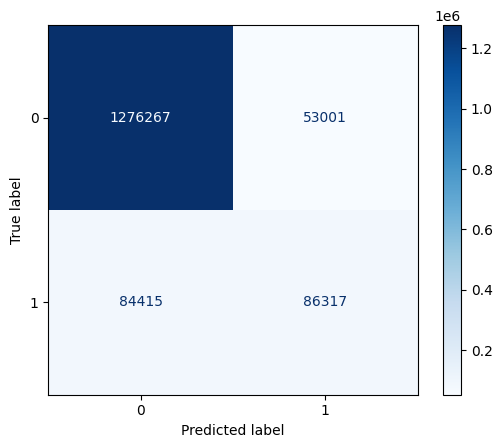

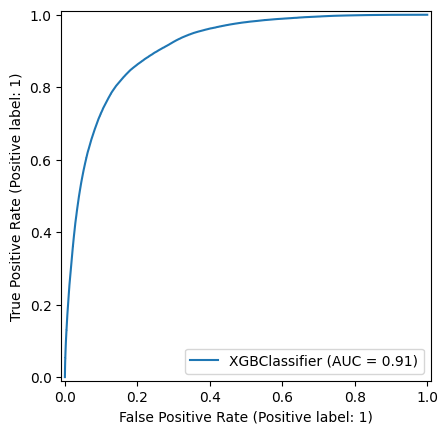

In [87]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['0', '1']
)

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

In [88]:
scores_Gini_dict['XGBoost'] = {
        'Train': 2 * roc_auc_score(y_train, y_pred_train_xgb) - 1,
        'Test': 2 * roc_auc_score(y_test, y_pred_test_xgb) - 1,
    }

scores_F1_dict['XGBoost'] = {
        'Train': f1_train_xgb,
        'Test': f1_test_xgb,
}


In [89]:
scores_Gini_dict

{'ANNs': {'Train': 0.8454433542955191, 'Test': 0.789030133988986},
 'XGBoost': {'Train': 0.5774373776157247, 'Test': 0.578106770131922}}

In [90]:
scores_F1_dict

{'ANNs': {'Train': 0.5626521386345196, 'Test': 0.5629723976424202},
 'XGBoost': {'Train': 0.6127720640994977, 'Test': 0.5891702314212078}}

# ✔️ 3. Random Forest Classifier

In [91]:
we_are_learning = False

if we_are_learning:
    param_grid = dict(
     n_estimators=stats.randint(100, 1500),
     max_depth=stats.randint(10, 100),  #max_depth (максимальная глубина деревьев).
     min_samples_split=stats.randint(1, 10), #min_samples_split (минимальное количество примеров для разбиения узла).
     min_samples_leaf=stats.randint(1, 10), #min_samples_leaf (минимальное количество примеров в листе).
     #max_features (ограничить число признаков для разбиения).
    )

    rf_clf = RandomForestClassifier(n_estimators=10)
    rf_cv = RandomizedSearchCV(
        rf_clf, param_grid, cv=3, n_iter=60,
        scoring='roc_auc', n_jobs=-1, verbose=1
    )
    rf_cv.fit(X_train, y_train)
    best_params = rf_cv.best_params_
else:
    best_params = dict(
    n_estimators=563,
    max_depth=13,  #max_depth (максимальная глубина деревьев).
    min_samples_split=8, #min_samples_split (минимальное количество примеров для разбиения узла).
    min_samples_leaf=8, #min_samples_leaf (минимальное количество примеров в листе).
    #max_features (ограничить число признаков для разбиения).
    )

print(f"Best Parameters: {best_params}")
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

Best Parameters: {'n_estimators': 563, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 8}


RandomForestClassifier(max_depth=13, min_samples_leaf=8, min_samples_split=8,
                       n_estimators=563)

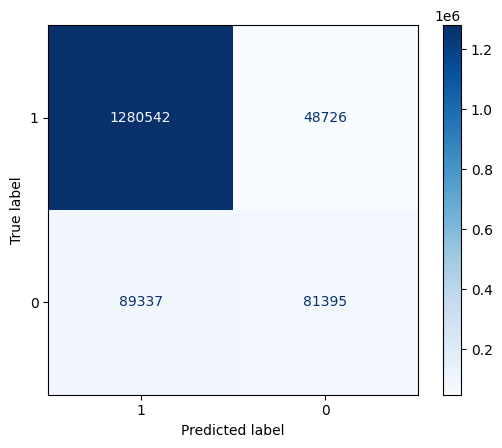

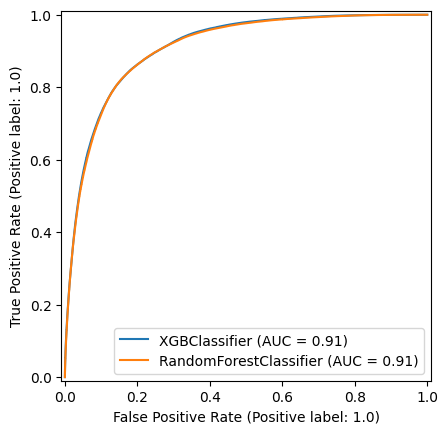

In [92]:
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test,
                             cmap='Blues', values_format='d',
                             display_labels=['1', '0'])

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)

In [93]:
# Step: Predict default probabilities on the training set
y_train_proba_pred_rf = rf_clf.predict_proba(X_train)[:, 1]
f1_train_rf, cutoff_rf, y_pred_train_rf = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_rf, verbose = True, text = "train")
y_test_proba_pred_rf = rf_clf.predict_proba(X_test)[:, 1]
f1_test_rf, _ , y_pred_test_rf= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_rf, cutoff_rf, verbose = True, text = "test")

train
Optimal cutoff: 0.35504069993824205
Accuracy: 0.941
F1 Score: 0.6472135852666826
test
Optimal cutoff: 0.35504069993824205
Accuracy: 0.895646
F1 Score: 0.5831986430676895


In [94]:
factor_utils.print_score(y_train, y_pred_train_rf, train=True)
factor_utils.print_score(y_test, y_pred_test_rf, train=False)

Train Result:
Accuracy Score: 94.10%
_______________________________________________
CLASSIFICATION REPORT:
               0.0     1.0  accuracy  macro avg  weighted avg
precision     0.97    0.65      0.94       0.81          0.94
recall        0.97    0.65      0.94       0.81          0.94
f1-score      0.97    0.65      0.94       0.81          0.94
support   45819.00 4181.00      0.94   50000.00      50000.00
_______________________________________________
Confusion Matrix: 
 [[44344  1475]
 [ 1475  2706]]

 F1 score: 64.72%
 Gini: 61.37%

Test Result:
Accuracy Score: 89.56%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0       1.0  accuracy  macro avg  weighted avg
precision       0.95      0.53      0.90       0.74          0.91
recall          0.93      0.64      0.90       0.78          0.90
f1-score        0.94      0.58      0.90       0.76          0.90
support   1329268.00 170732.00      0.90 1500000.00    1500000.00
____________

In [95]:
scores_Gini_dict['Random Forest'] = {
        'Train': 2 * roc_auc_score(y_train, y_pred_train_rf) - 1,
        'Test': 2 * roc_auc_score(y_test, y_pred_test_rf) - 1,
    }

scores_F1_dict['Random Forest'] = {
        'Train': f1_train_rf,
        'Test': f1_test_rf,
}

In [96]:
scores_Gini_dict


{'ANNs': {'Train': 0.8454433542955191, 'Test': 0.789030133988986},
 'XGBoost': {'Train': 0.5774373776157247, 'Test': 0.578106770131922},
 'Random Forest': {'Train': 0.6150216998043196, 'Test': 0.5697193551457866}}

In [97]:

scores_F1_dict

{'ANNs': {'Train': 0.5626521386345196, 'Test': 0.5629723976424202},
 'XGBoost': {'Train': 0.6127720640994977, 'Test': 0.5891702314212078},
 'Random Forest': {'Train': 0.6472135852666826, 'Test': 0.5831986430676895}}

# ✔️ 4. Logistic regression

In [98]:
# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [99]:
# Step: Predict default probabilities on the training set
y_train_proba_pred_logreg = logreg.predict_proba(X_train)[:, 1]
f1_train_logreg, cutoff_logreg, y_pred_train_logreg = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_logreg, verbose = True, text = "train")
y_test_proba_pred_logreg = logreg.predict_proba(X_test)[:, 1]
f1_test_logreg, _ , y_pred_test_logreg= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_logreg, cutoff_logreg, verbose = True, text = "test")

train
Optimal cutoff: 0.3380419142601014
Accuracy: 0.92216
F1 Score: 0.5345611097823487
test
Optimal cutoff: 0.3380419142601014
Accuracy: 0.8791366666666667
F1 Score: 0.5330613527428573


In [100]:
factor_utils.print_score(y_train, y_pred_train_logreg, train=True)
factor_utils.print_score(y_test, y_pred_test_logreg, train=False)

Train Result:
Accuracy Score: 92.22%
_______________________________________________
CLASSIFICATION REPORT:
               0.0     1.0  accuracy  macro avg  weighted avg
precision     0.96    0.53      0.92       0.75          0.92
recall        0.96    0.53      0.92       0.75          0.92
f1-score      0.96    0.53      0.92       0.75          0.92
support   45819.00 4181.00      0.92   50000.00      50000.00
_______________________________________________
Confusion Matrix: 
 [[43873  1946]
 [ 1946  2235]]

 F1 score: 53.46%
 Gini: 49.28%

Test Result:
Accuracy Score: 87.91%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0       1.0  accuracy  macro avg  weighted avg
precision       0.95      0.48      0.88       0.71          0.89
recall          0.91      0.61      0.88       0.76          0.88
f1-score        0.93      0.53      0.88       0.73          0.89
support   1329268.00 170732.00      0.88 1500000.00    1500000.00
____________

In [101]:
scores_Gini_dict['Logistic regression'] = {
        'Train': 2 * roc_auc_score(y_train, y_pred_train_logreg) - 1,
        'Test': 2 * roc_auc_score(y_test, y_pred_test_logreg) - 1,
    }
scores_Gini_dict

{'ANNs': {'Train': 0.8454433542955191, 'Test': 0.789030133988986},
 'XGBoost': {'Train': 0.5774373776157247, 'Test': 0.578106770131922},
 'Random Forest': {'Train': 0.6150216998043196, 'Test': 0.5697193551457866},
 'Logistic regression': {'Train': 0.49208964597912286,
  'Test': 0.5203226877873943}}

In [102]:
scores_F1_dict['Logistic regression'] = {
        'Train': f1_train_logreg,
        'Test': f1_test_logreg,
}
scores_F1_dict

{'ANNs': {'Train': 0.5626521386345196, 'Test': 0.5629723976424202},
 'XGBoost': {'Train': 0.6127720640994977, 'Test': 0.5891702314212078},
 'Random Forest': {'Train': 0.6472135852666826, 'Test': 0.5831986430676895},
 'Logistic regression': {'Train': 0.5345611097823487,
  'Test': 0.5330613527428573}}

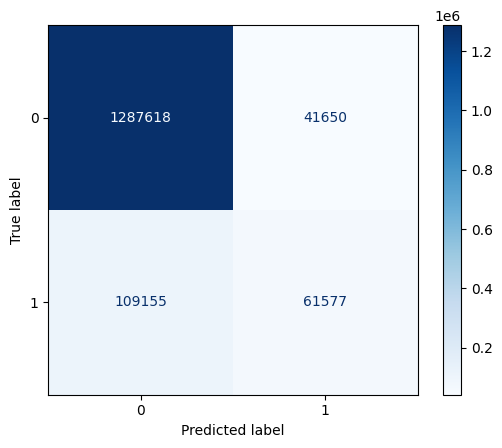

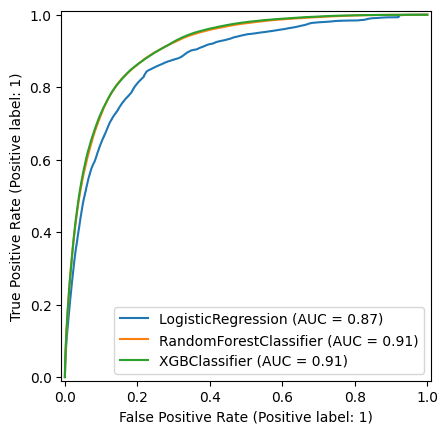

In [103]:
disp = ConfusionMatrixDisplay.from_estimator(
    logreg, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['0', '1']
)

disp = RocCurveDisplay.from_estimator(logreg, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)
RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test, ax=disp.ax_)


# 📊 Comparing Models Prerformance

In [119]:
#ml_models = {
#    'Random Forest': rf_clf,
#    'XGBoost': xgb_clf,
#    'ANNs': model_ann,
#    'Logreg': logreg,
#}

#for model2 in ml_models:
#    print(f"{model2.upper():{30}} roc_auc_score: {roc_auc_score(y_test, ml_models[model2].predict(X_test)):.3f}")

In [104]:
scores_F1_df = pd.DataFrame(scores_F1_dict)
barh_plot_F1 = scores_F1_df.hvplot.barh(
    width=500, height=400,
    title="F1 of ML Models", xlabel="F1 Scores",
    alpha=0.4, legend='top'
)

baseline_F1  = 0.503
Hline = hv.HLine(baseline_F1).opts(color='red', line_width=2)
# Совмещение графиков
barh_with_Hline_F1 = barh_plot_F1 * Hline
barh_with_Hline_F1

:Overlay
   .Bars.I  :Bars   [index,Variable]   (value)
   .HLine.I :HLine   [x,y]

In [105]:
scores_F1_dict

{'ANNs': {'Train': 0.5626521386345196, 'Test': 0.5629723976424202},
 'XGBoost': {'Train': 0.6127720640994977, 'Test': 0.5891702314212078},
 'Random Forest': {'Train': 0.6472135852666826, 'Test': 0.5831986430676895},
 'Logistic regression': {'Train': 0.5345611097823487,
  'Test': 0.5330613527428573}}

In [106]:
scores_df = pd.DataFrame(scores_Gini_dict)
barh_plot_Gini = scores_df.hvplot.barh(
    width=500, height=400,
    title="Gini Scores of ML Models", xlabel="ROC Scores",
    alpha=0.4, legend='top'
)

baseline_ROC_AUC  = 0.667
baseline_Gini = 2 * baseline_ROC_AUC - 1
Hline_Gini = hv.HLine(baseline_Gini).opts(color='red', line_width=2)
# Совмещение графиков
barh_with_Hline_Gini = barh_plot_Gini * Hline_Gini
barh_with_Hline_Gini

:Overlay
   .Bars.I  :Bars   [index,Variable]   (value)
   .HLine.I :HLine   [x,y]

In [107]:
scores_Gini_dict

{'ANNs': {'Train': 0.8454433542955191, 'Test': 0.789030133988986},
 'XGBoost': {'Train': 0.5774373776157247, 'Test': 0.578106770131922},
 'Random Forest': {'Train': 0.6150216998043196, 'Test': 0.5697193551457866},
 'Logistic regression': {'Train': 0.49208964597912286,
  'Test': 0.5203226877873943}}